# NBA Team Analytics Pipeline

## Necessary Imports

In [43]:
import time
import re
from PIL import Image
import requests
import urllib
import urllib.request
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5g}'.format)
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import  OffsetImage

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [44]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]

## Webscrape and Clean NBA Team Data into Pandas DF

In [45]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df = pd.DataFrame(rows, columns=columns)
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)


df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A

df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

df['FRAC_ATT_2PT'] = df.FG2A / df.FGA
df['FRAC_ATT_3PT'] = df.FG3A / df.FGA

df['FRAC_MK_2PT'] = df.FG2M / df.FGM
df['FRAC_MK_3PT'] = df.FG3M / df.FGM

df['FRAC_PTS_2PT'] = df.FG2_PTS / df.PTS
df['FRAC_PTS_3PT'] = df.FG3_PTS / df.PTS
df['FRAC_PTS_FT'] = df.FTM / df.PTS 

df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

def home_or_away(string):
    if string[4]=='@': return 'AWAY'
    elif string[4]=='v': return 'HOME'
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))

# ADD OPONENTS RECORD ON GAME DATE
# ADD TEAM RECORD ON GAME DATE

df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]
#df['DATE_MATCHUP'] = df['GAME_DATE'] + ' ' + df['MATCHUP'].str[4:]

df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME     GAME_ID  \
0     22022  1610612764               WAS     Washington Wizards  0022200660   
1     22022  1610612744               GSW  Golden State Warriors  0022200660   
2     22022  1610612761               TOR        Toronto Raptors  0022200659   
3     22022  1610612752               NYK        New York Knicks  0022200659   
4     22022  1610612739               CLE    Cleveland Cavaliers  0022200658   

    GAME_DATE      MATCHUP    WL  MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  \
0  2023-01-16  WAS vs. GSW  None   60   18   34   0.529     5    11    0.455   
1  2023-01-16    GSW @ WAS  None   60   17   35   0.486     7    19    0.368   
2  2023-01-16    TOR @ NYK  None   60   15   34   0.441     5    16    0.313   
3  2023-01-16  NYK vs. TOR  None   60   15   37   0.405     3    15      0.2   
4  2023-01-16  CLE vs. NOP  None   60   14   30   0.467     3    11    0.273   

   FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0    9   11   0.818     2    10   12   12    3    0    3   4   50           2   
1    7    7       1     5    13   18    8    2    0    4  11   48          -2   
2   11   15   0.733     3    15   18   11    2    4    1   4   46           6   
3    7    8   0.875     6    12   18    8    1    1    3   9   40          -6   
4    3    7   0.429     4    14   18    9    0    3    9   7   34          -9   

   FG2M  FG2A  FG2_PTS  FG3_PTS  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  \
0    13    23       26       15       0.67647       0.32353      0.72222   
1    10    16       20       21       0.45714       0.54286      0.58824   
2    10    18       20       15       0.52941       0.47059      0.66667   
3    12    22       24        9       0.59459       0.40541          0.8   
4    11    19       22        9       0.63333       0.36667      0.78571   

   FRAC_MK_3PT  FRAC_PTS_2PT  FRAC_PTS_3PT  FRAC_PTS_FT OPP_TEAM_ABBR  \
0      0.27778          0.52           0.3         0.18           GSW   
1      0.41176       0.41667        0.4375      0.14583           WAS   
2      0.33333       0.43478       0.32609      0.23913           NYK   
3          0.2           0.6         0.225        0.175           TOR   
4      0.21429       0.64706       0.26471     0.088235           NOP   

   OPP_PTS  MONTH  YEAR HOME_AWAY CONFERENCE OPP_CONFERENCE   DATE_MATCHUP  
0       48      1  2023      HOME       EAST           WEST  01-16 vs. GSW  
1       50      1  2023      AWAY       WEST           EAST    01-16 @ WAS  
2       40      1  2023      AWAY       EAST           EAST    01-16 @ NYK  
3       46      1  2023      HOME       EAST           EAST  01-16 vs. TOR  
4       43      1  2023      HOME       EAST           EAST  01-16 vs. NOP

In [46]:
ids = list(df.TEAM_ID.unique())
teams = list(df.TEAM_NAME.unique())

for i in range(len(teams)):
    team_id_dict[teams[i]]=ids[i]

## Create team averages dataframes for offense and defense

In [47]:
pivot_team_avg = pd.pivot_table(df, index=['TEAM_NAME','TEAM_ABBREVIATION'], aggfunc = 'mean')
df_team_avg = pivot_team_avg.reset_index()
df_team_avg.loc[30] = df_team_avg.drop(['TEAM_NAME','TEAM_ABBREVIATION'], axis=1).mean()
df_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_team_avg = df_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
df_team_avg = df_team_avg.drop(['MONTH','YEAR'],axis=1)
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR', 'PTS']
df_team_avg = df_team_avg[cols_to_move + [x for x in df_team_avg.columns if x not in cols_to_move]]

df_team_avg.head()

TEAM_NAME TEAM_ABBR    PTS    AST    BLK   DREB   FG2A   FG2M  \
0      Atlanta Hawks       ATL 113.11 23.568 4.9545     33 60.477 32.341   
1     Boston Celtics       BOS 118.76 26.911 5.3556 34.778 46.378 26.667   
2      Brooklyn Nets       BKN 113.88 26.286 7.0238 32.952 52.738 30.571   
3  Charlotte Hornets       CHA 112.16 25.289 4.8667     33   59.2 30.689   
4      Chicago Bulls       CHI 114.55 24.409 4.6364 33.682 58.114 31.705   

   FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  FG_PCT  \
0   64.682 30.318  10.25   0.3425    30.75 90.795 42.591 0.47282   
1   53.333 41.933 15.556  0.36967   46.667 88.311 42.222 0.47929   
2   61.143 31.381  12.19   0.3891   36.571 84.119 42.762 0.50881   
3   61.378 33.511 11.067  0.33002     33.2 92.711 41.756 0.45162   
4   63.409  29.25 10.909  0.36834   32.727 87.364 42.614 0.48839   

   FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0        0.6648        0.3352      0.75595      0.24405       0.56913   
1       0.52473       0.47527      0.63187      0.36813       0.44964   
2       0.62565       0.37435      0.71325      0.28675       0.53569   
3       0.63892       0.36108      0.73504      0.26496       0.54828   
4       0.66426       0.33574      0.74444      0.25556       0.55516   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.27223      0.15864 21.568 17.682 0.82025 237.39   113.86 10.205   
1       0.39109      0.15927 22.533 18.756 0.83707 242.22   112.29 9.5556   
2       0.32131        0.143 20.238 16.167 0.79871  240.6    110.6 7.5714   
3       0.29402      0.15769 23.444 17.578 0.74513 243.33   118.93 12.356   
4       0.28432      0.16051 22.523 18.409  0.8118 242.84   115.18 8.4773   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV  
0 18.932       -0.75 43.205 6.9773 1.6106e+09 12.545  
1 18.756      6.4667 44.333 6.3778 1.6106e+09 13.289  
2 21.595      3.2857 40.524 7.0714 1.6106e+09 14.571  
3   21.2     -6.7778 45.356 7.7111 1.6106e+09 13.756  
4 19.727    -0.63636 42.159    7.5 1.6106e+09 13.659

In [48]:
pivot_defense_allowed_team_avg = pd.pivot_table(df, index=['OPP_TEAM_ABBR'], aggfunc = 'mean')
df_defense_allowed_team_avg = pivot_defense_allowed_team_avg.reset_index()
df_defense_allowed_team_avg.loc[30] = df_defense_allowed_team_avg.drop(['OPP_TEAM_ABBR'], axis=1).mean()
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBREVIATION'})
df_defense_allowed_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_defense_allowed_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_defense_allowed_team_avg['TEAM_NAME'] = df_defense_allowed_team_avg['TEAM_ABBREVIATION'].map(team_abbr_name_dict)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.drop(['YEAR','TEAM_ID'], axis=1)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_defense_allowed_team_avg = df_defense_allowed_team_avg[cols_to_move + [x for x in df_defense_allowed_team_avg.columns if x not in cols_to_move]]
df_defense_allowed_team_avg.rename(columns=lambda x: 'OPP_'+x, inplace=True)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBR','OPP_TEAM_NAME':'TEAM_NAME'})


# Optional: Merge Offensive and Defensive Avg DFs
'''
df_team_avg = pd.merge(df_team_avg, 
                       df_defense_allowed_team_avg,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_avg = df_team_avg.drop(['TEAM_NAME_y', 'OPP_PTS_y'],axis=1)
df_team_avg = df_team_avg.rename(columns={'TEAM_NAME_x':'TEAM_NAME','OPP_PTS_x':'OPP_PTS'})
'''

df_defense_allowed_team_avg.head()

TEAM_NAME TEAM_ABBR  OPP_AST  OPP_BLK  OPP_DREB  OPP_FG2A  \
0      Atlanta Hawks       ATL   24.977   5.2045    35.227    56.568   
1      Brooklyn Nets       BKN   22.762    3.881    32.143    55.429   
2     Boston Celtics       BOS   22.556   3.7333    33.889    57.511   
3  Charlotte Hornets       CHA     26.8   6.1333    35.356    53.422   
4      Chicago Bulls       CHI   26.432   5.1364    34.136    50.932   

   OPP_FG2M  OPP_FG2_PTS  OPP_FG3A  OPP_FG3M  OPP_FG3_PCT  OPP_FG3_PTS  \
0    30.795       61.591     32.25        11      0.33302           33   
1    27.929       55.857    32.762    11.976      0.36452       35.929   
2    30.689       61.378    32.467    11.578      0.35656       34.733   
3    29.911       59.822    35.911    13.067      0.36089         39.2   
4    28.273       56.545    36.909    13.614      0.36852       40.841   

   OPP_FGA  OPP_FGM  OPP_FG_PCT  OPP_FRAC_ATT_2PT  OPP_FRAC_ATT_3PT  \
0   88.818   41.795      0.4732           0.64127           0.35873   
1    88.19   39.905     0.45302           0.62656           0.37344   
2   89.978   42.267     0.47064           0.63867           0.36133   
3   89.333   42.978     0.48238           0.59742           0.40258   
4   87.841   41.886      0.4787           0.58002           0.41998   

   OPP_FRAC_MK_2PT  OPP_FRAC_MK_3PT  OPP_FRAC_PTS_2PT  OPP_FRAC_PTS_3PT  \
0          0.74236          0.25764            0.5472           0.28273   
1          0.69744          0.30256           0.50579           0.32392   
2          0.72619          0.27381           0.54786           0.30815   
3          0.69481          0.30519           0.50441           0.32797   
4          0.67413          0.32587           0.49227           0.35384   

   OPP_FRAC_PTS_FT  OPP_FTA  OPP_FTM  OPP_FT_PCT  OPP_MIN  OPP_MONTH  \
0          0.17007   23.977   19.273     0.80464   237.39     9.3409   
1          0.17029   24.595    18.81     0.76471    240.6     9.7143   
2          0.14399   20.711   16.178     0.78031   242.22     9.1778   
3          0.16762   25.378   19.911     0.79009   243.33     9.4222   
4          0.15389   22.955   17.795     0.77632   242.84     9.3636   

   OPP_OPP_PTS  OPP_OREB  OPP_PF  OPP_PLUS_MINUS  OPP_PTS  OPP_REB  OPP_STL  \
0       113.11    11.205  19.909            0.75   113.86   46.432   7.0455   
1       113.88    11.429  17.976         -3.2857    110.6   43.571    7.381   
2       118.76    9.7333  19.756         -6.4667   112.29   43.622   6.3556   
3       112.16      10.8  20.667          6.7778   118.93   46.156   6.5778   
4       114.55    9.6136  19.159         0.63636   115.18    43.75   6.5227   

   OPP_TOV  
0   14.773  
1   14.238  
2   13.067  
3   14.911  
4   15.023

## Advanced Shooting Analytics Dataframe

In [49]:
tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2023.html#shooting-team")

df_team_advshot = tables[12]
df_team_advshot.columns = [' '.join(col) for col in df_team_advshot.columns]
df_team_advshot.columns = df_team_advshot.columns.str.replace("Unnamed:", "")
df_team_advshot.columns = df_team_advshot.columns.str.replace("_level_0", "")
df_team_advshot = df_team_advshot.drop([' 0 Rk',
                                        ' 6  6_level_1',
                                        ' 13  13_level_1',
                                        ' 20  20_level_1',
                                        ' 23  23_level_1',
                                        ' 26  26_level_1',
                                        ' 29  29_level_1'], axis=1)

df_team_advshot = df_team_advshot.rename(columns={' 1 Team':'TEAM_NAME',
                                                  ' 2 G':'G',
                                                  ' 3 MP':'MP',
                                                  ' 4 FG%':'FG%',
                                                  ' 5 Dist.':'Dist'})


df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_NAME']
df_team_advshot['TEAM_ABBR']=df_team_advshot['TEAM_ABBR'].map(team_name_abbr_dict)

cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_team_advshot = df_team_advshot[cols_to_move + [x for x in df_team_advshot.columns if x not in cols_to_move]]


df_team_advshot.head()

TEAM_NAME TEAM_ABBR   G     MP   FG%  Dist  \
0      Atlanta Hawks       ATL  43  10445  0.47  13.3   
1     Boston Celtics       BOS  44  10660  0.47  14.2   
2      Brooklyn Nets       BKN  42  10105 0.452  13.4   
3      Chicago Bulls       CHI  44  10685 0.477  14.4   
4  Charlotte Hornets       CHA  44  10710 0.481  14.1   

   % of FGA by Distance 2P  % of FGA by Distance 0-3  \
0                    0.636                      0.29   
1                    0.639                     0.206   
2                    0.629                     0.275   
3                     0.58                      0.27   
4                      0.6                     0.264   

   % of FGA by Distance 3-10  % of FGA by Distance 10-16  \
0                      0.176                         0.1   
1                      0.224                       0.113   
2                      0.203                       0.087   
3                      0.163                       0.085   
4                      0.184                       0.088   

   % of FGA by Distance 16-3P  % of FGA by Distance 3P  FG% by Distance 2P  \
0                       0.069                    0.364               0.544   
1                       0.096                    0.361               0.535   
2                       0.064                    0.371               0.504   
3                       0.062                     0.42               0.555   
4                       0.064                      0.4               0.561   

   FG% by Distance 0-3  FG% by Distance 3-10  FG% by Distance 10-16  \
0                0.688                 0.435                  0.407   
1                0.688                 0.464                  0.442   
2                0.662                 0.383                   0.38   
3                0.693                 0.457                  0.433   
4                0.681                 0.462                  0.465   

   FG% by Distance 16-3P  FG% by Distance 3P  % of FG Ast'd 2P  \
0                  0.413               0.342             0.505   
1                   0.48               0.355             0.447   
2                  0.373               0.366             0.461   
3                  0.381               0.369             0.526   
4                  0.478               0.361             0.516   

   % of FG Ast'd 3P  Dunks %FGA  Dunks Md.  Layups %FGA  Layups Md.  \
0             0.851       0.065        231        0.292         652   
1             0.756       0.051        184        0.276         597   
2             0.825       0.053        182        0.301         582   
3              0.85       0.062        220        0.264         600   
4             0.861       0.065        218        0.271         587   

   Corner %3PA  Corner 3P%  
0         0.23        0.38  
1        0.173       0.375  
2         0.23       0.397  
3        0.243       0.343  
4        0.254       0.419

## Function Field Goal Trends based on Distance

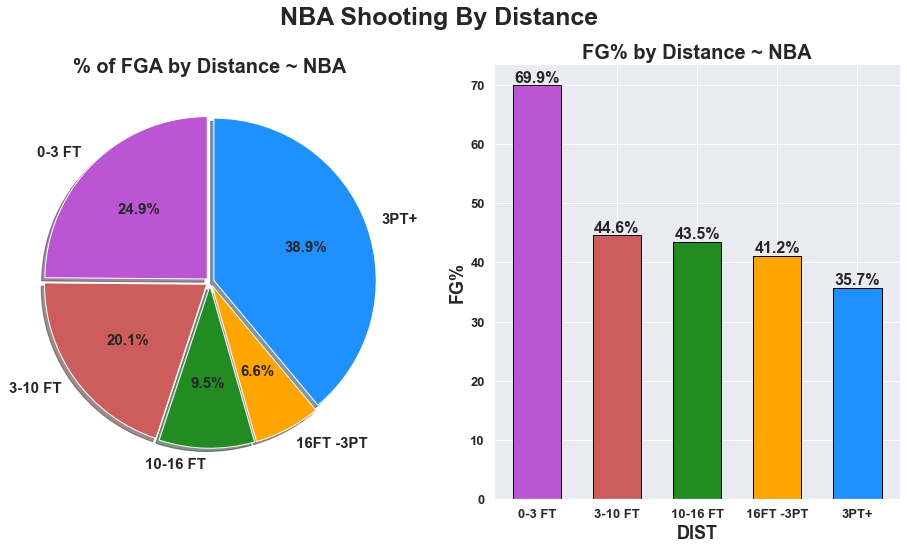

In [50]:
def nba_fg_by_dist():
    plt.rcParams["figure.figsize"] = (10,10)
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']

    att_dist_data = df_team_advshot[['% of FGA by Distance 0-3',
                             '% of FGA by Distance 3-10', 
                             '% of FGA by Distance 10-16', 
                             '% of FGA by Distance 16-3P', 
                             '% of FGA by Distance 3P']].mean()
    
    
    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    ax[0].pie(att_dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title('% of FGA by Distance ~ NBA', fontsize=20, fontweight='bold')
    
    per_dist_data = df_team_advshot[['FG% by Distance 0-3',
                                     'FG% by Distance 3-10',
                                     'FG% by Distance 10-16',
                                     'FG% by Distance 16-3P',
                                     'FG% by Distance 3P']].mean()*100
    
    per_dist = list(per_dist_data.keys())
    per_values = list(per_dist_data)
    
    barWidth = 0.6
    
    ax[1].bar(per_dist, per_values, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title('FG% by Distance ~ NBA', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
        
    plt.suptitle('NBA Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
nba_fg_by_dist()

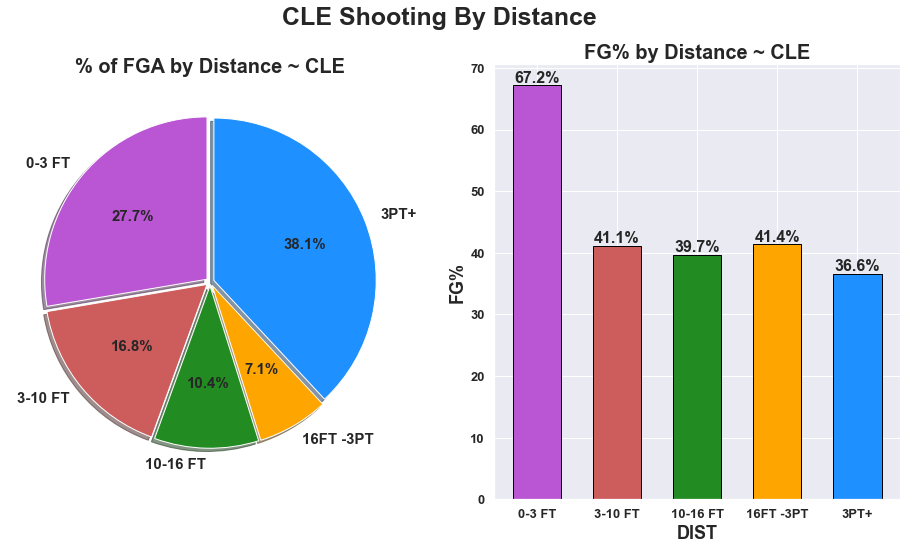

In [51]:
def team_fg_by_dist(abbr):
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']
    barWidth = 0.6
    
    plt.rcParams["figure.figsize"] = (10,10)
    
    dist_data = list(np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3P'].item()]))
    
    dist_data_pct = np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3P'].item()])*100

    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].pie(dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title(f'% of FGA by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    
    ax[1].bar(labels, dist_data_pct, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title(f'FG% by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
    
    plt.suptitle(f'{abbr} Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
team_fg_by_dist('CLE')

## Function to return a teams dataframe

In [52]:
def get_team_df(TEAM_ABBR):
    team_df = df[df['TEAM_ABBREVIATION']==TEAM_ABBR]
    return team_df

## Webscrape NBA records data into a pandas dataframe

In [53]:
columns = ['TEAM_ABBR','CONFERENCE','GAMES','WINS','LOSES','WIN_PER','LAST_10_WINS','LAST_10_LOSES','HOME_WINS','HOME_LOSES','AWAY_WINS','AWAY_LOSES',
           'WEST_WINS', 'WEST_LOSES', 'EAST_WINS', 'EAST_LOSES']
data_records=[]
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

for i in df.TEAM_ABBREVIATION.unique(): 
    
    team_abbr = i
    
    games = df[(df['TEAM_ABBREVIATION']==i)]['WL'].count() 
    
    wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')]['WL'].count()
    loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')]['WL'].count()
    
    win_per = wins/games
    
    last_10_df = get_team_df(i).head(10)
    
    last_10_wins = last_10_df[last_10_df['WL']=='W']['WL'].count()
    last_10_loses = last_10_df[last_10_df['WL']=='L']['WL'].count()
    
    home_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    home_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    
    away_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    away_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    
    west_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    west_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    
    east_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    east_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    
    conference = conferences[i]
    
    values = [team_abbr, conference, games, wins, loses, win_per, last_10_wins, last_10_loses, home_wins, home_loses, away_wins, away_loses,
              west_wins, west_loses, east_wins, east_loses]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data_records.append(a_dictionary)
    
df_records=pd.DataFrame(data_records).sort_values('WINS',ascending=False).reset_index(drop=True)


df_records.loc[30] = df_records[df_records.drop(['TEAM_ABBR', 'CONFERENCE'], axis=1).columns].mean()

df_records.loc[30, 'TEAM_ABBR']='NBA'
df_records.loc[30, 'CONFERENCE']='NBA'


df_records

TEAM_ABBR CONFERENCE  GAMES   WINS  LOSES  WIN_PER  LAST_10_WINS  \
0        BOS       EAST     45     33     12  0.73333             8   
1        DEN       WEST     43     30     13  0.69767             8   
2        MEM       WEST     42     29     13  0.69048             9   
3        CLE       EAST     44     27     17  0.61364             5   
4        MIL       EAST     43     27     16  0.62791             5   
5        PHI       EAST     43     27     16  0.62791             7   
6        BKN       EAST     42     27     15  0.64286             7   
7        NOP       EAST     43     26     17  0.60465             4   
8        NYK       EAST     44     25     19  0.56818             7   
9        DAL       WEST     45     24     21  0.53333             5   
10       MIA       EAST     44     24     20  0.54545             6   
11       SAC       WEST     42     24     18  0.57143             7   
12       LAC       WEST     45     23     22  0.51111             3   
13       IND       EAST     44     23     21  0.52273             5   
14       MIN       WEST     44     22     22      0.5             6   
15       UTA       WEST     46     22     24  0.47826             3   
16       PHX       WEST     44     21     23  0.47727             2   
17       GSW       WEST     43     21     22  0.48837             5   
18       OKC       WEST     44     21     23  0.47727             6   
19       ATL       EAST     43     21     22  0.48837             4   
20       POR       WEST     43     21     22  0.48837             4   
21       CHI       EAST     44     20     24  0.45455             5   
22       LAL       WEST     43     19     24  0.44186             6   
23       TOR       EAST     43     19     24  0.44186             4   
24       WAS       EAST     43     18     25   0.4186             5   
25       ORL       EAST     44     16     28  0.36364             3   
26       SAS       WEST     44     13     31  0.29545             2   
27       DET       EAST     47     12     35  0.25532             3   
28       CHA       EAST     45     11     34  0.24444             2   
29       HOU       WEST     43     10     33  0.23256             0   
30       NBA        NBA 43.733 21.867 21.867  0.50123        4.8667   

    LAST_10_LOSES  HOME_WINS  HOME_LOSES  AWAY_WINS  AWAY_LOSES  WEST_WINS  \
0               2         17           5         16           7         12   
1               2         19           3         11          10         22   
2               1         18           3         11          10         12   
3               4         18           4          9          13         10   
4               4         16           5         11          11         11   
5               3         17           7         10           9          9   
6               3         13           7         14           8          6   
7               5         17           5          9          12         16   
8               2         11          11         14           8          9   
9               5         16           6          8          15         17   
10              3         14           9         10          11         14   
11              3         14           9         10           9         12   
12              7         13          10         10          12         13   
13              4         15           9          8          12          6   
14              4         14           9          8          13         14   
15              7         14           8          8          16         13   
16              8         14           7          7          16         16   
17              4         17           5          4          17         13   
18              4         13           9          8          14         10   
19              5         11           9         10          13          5   
20              6         11           8         10          14         14   
21            

## Optional: Merge Records DF onto Team Averages DF

In [54]:
'''
df_team_avg = pd.merge(df_team_avg, 
                         df_records,
                         left_on='TEAM_ABBR',
                         right_on='TEAM_ABBR',
                         how='left')
df_team_avg.head()
'''

"\ndf_team_avg = pd.merge(df_team_avg, \n                         df_records,\n                         left_on='TEAM_ABBR',\n                         right_on='TEAM_ABBR',\n                         how='left')\ndf_team_avg.head()\n"

## Correlation Heatmap for Team Average DF

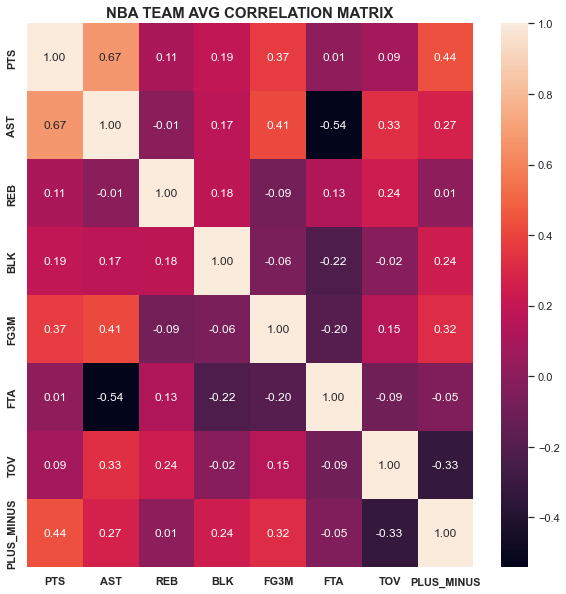

In [71]:
sns.heatmap(df_team_avg[['PTS','AST','REB','BLK','FG3M','FTA','TOV', 'PLUS_MINUS']].corr(), annot=True, fmt='.2f')
plt.title('NBA TEAM AVG CORRELATION MATRIX', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

## NBA Team PPG BoxPlot Function

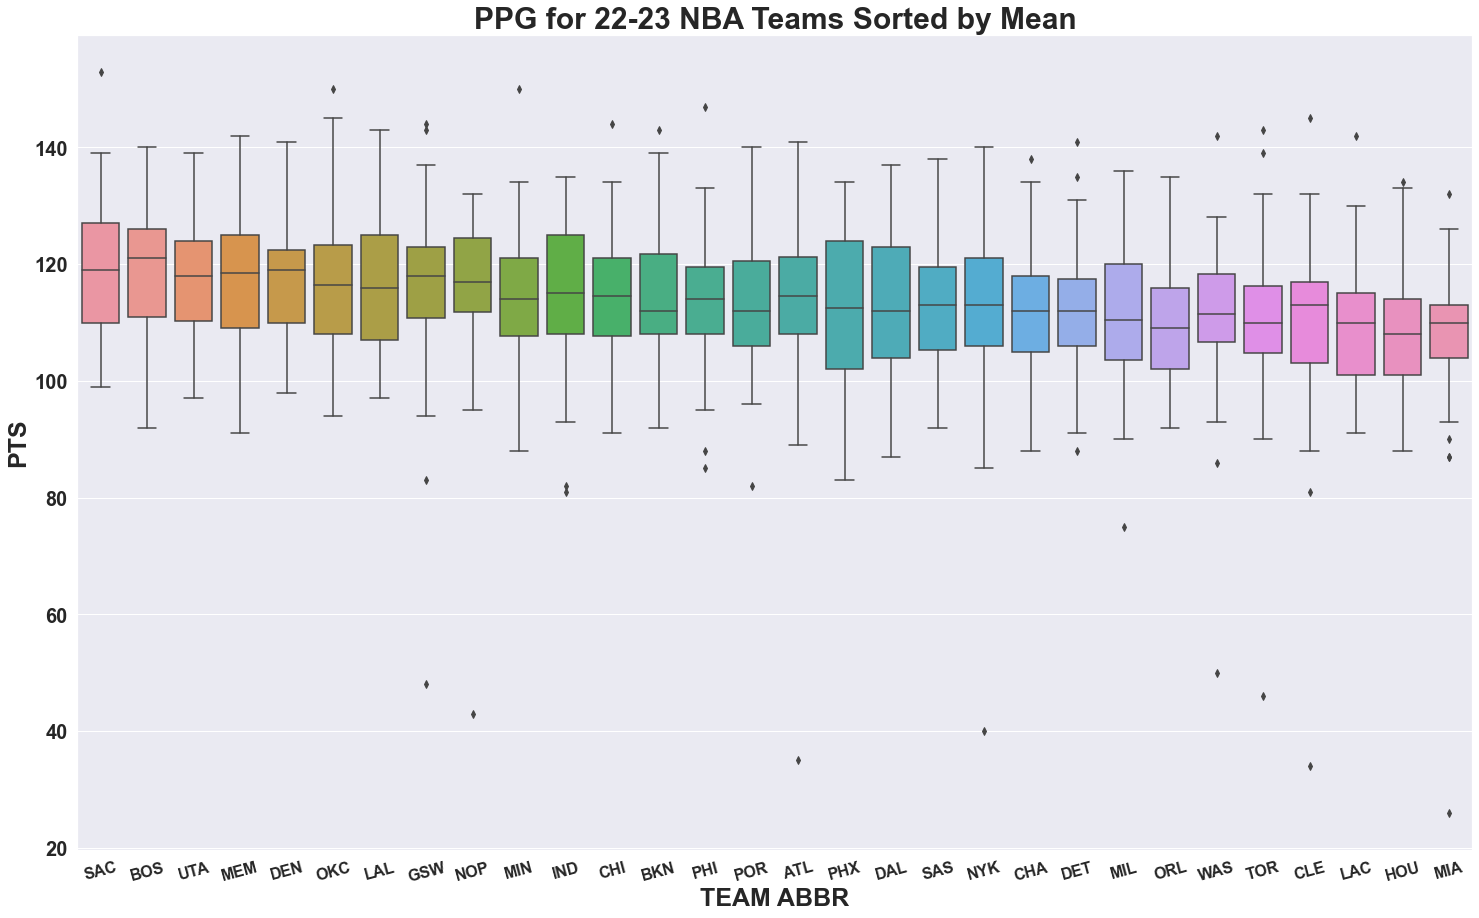

In [73]:
def team_ppg_boxplots():
    fig, (ax1) = plt.subplots(1, 1)

    sns.set(rc={'figure.figsize':(25,15)})

    means_ppg = df.groupby(['TEAM_ABBREVIATION'])['PTS'].mean().sort_values(ascending=[False])
    sns.boxplot(data=df, x=df.TEAM_ABBREVIATION, y='PTS', order=means_ppg.index, ax=ax1)
    ax1.set_title('PPG for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    #medians_ppg = df.groupby(['TEAM_ABBREVIATION'])['PTS'].median().sort_values(ascending=[False])
    #sns.boxplot(data=df, x=df.TEAM_ABBREVIATION, y='PTS', order=medians_ppg.index, ax=ax2)
    #ax2.set_title('PPG for 22-23 NBA Teams Sorted by Median', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')

    plt.ylabel('PTS', fontsize=25, fontweight='bold')


    plt.show()

team_ppg_boxplots()

## NBA Points Allowed Box Plot Function

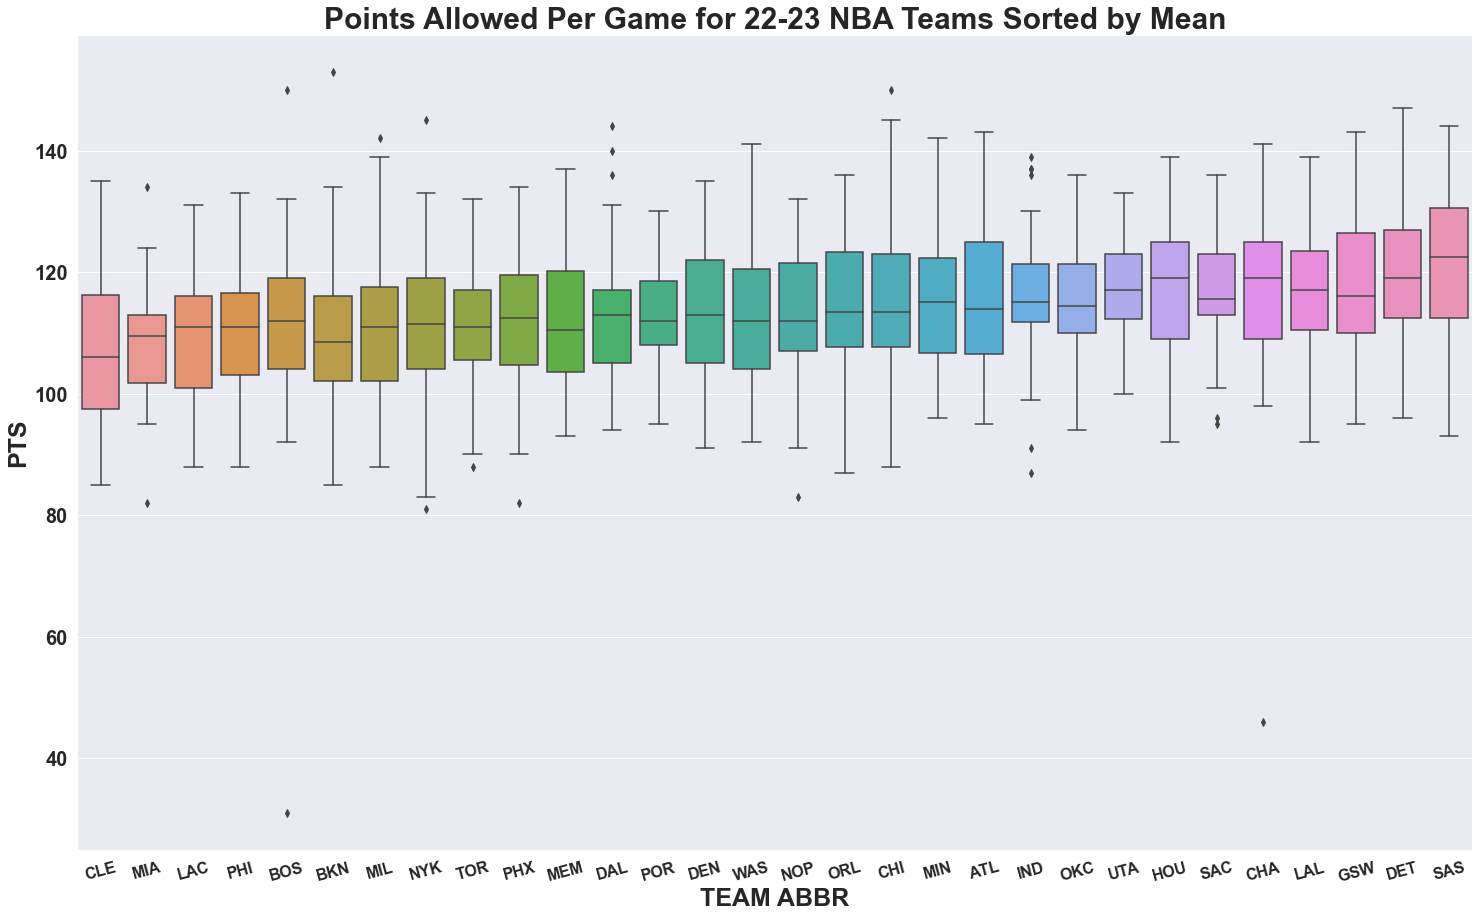

In [15]:
def pts_allowed_boxplots():
    fig, (ax1) = plt.subplots(1, 1)

    sns.set(rc={'figure.figsize':(25,15)})

    means_ppg = df.groupby(['OPP_TEAM_ABBR'])['PTS'].mean().sort_values(ascending=[True])
    sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y='PTS', order=means_ppg.index, ax=ax1)
    ax1.set_title('Points Allowed Per Game for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    #medians_ppg = df.groupby(['OPP_TEAM_ABBR'])['PTS'].median().sort_values(ascending=[True])
    #sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y='PTS', order=medians_ppg.index, ax=ax2)
    #ax2.set_title('Points Allowed Per Game for 22-23 NBA Teams Sorted by Medians', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')

    plt.ylabel('PTS', fontsize=25, fontweight='bold')

    plt.show()

pts_allowed_boxplots()

## Plus-Minus Plot Function

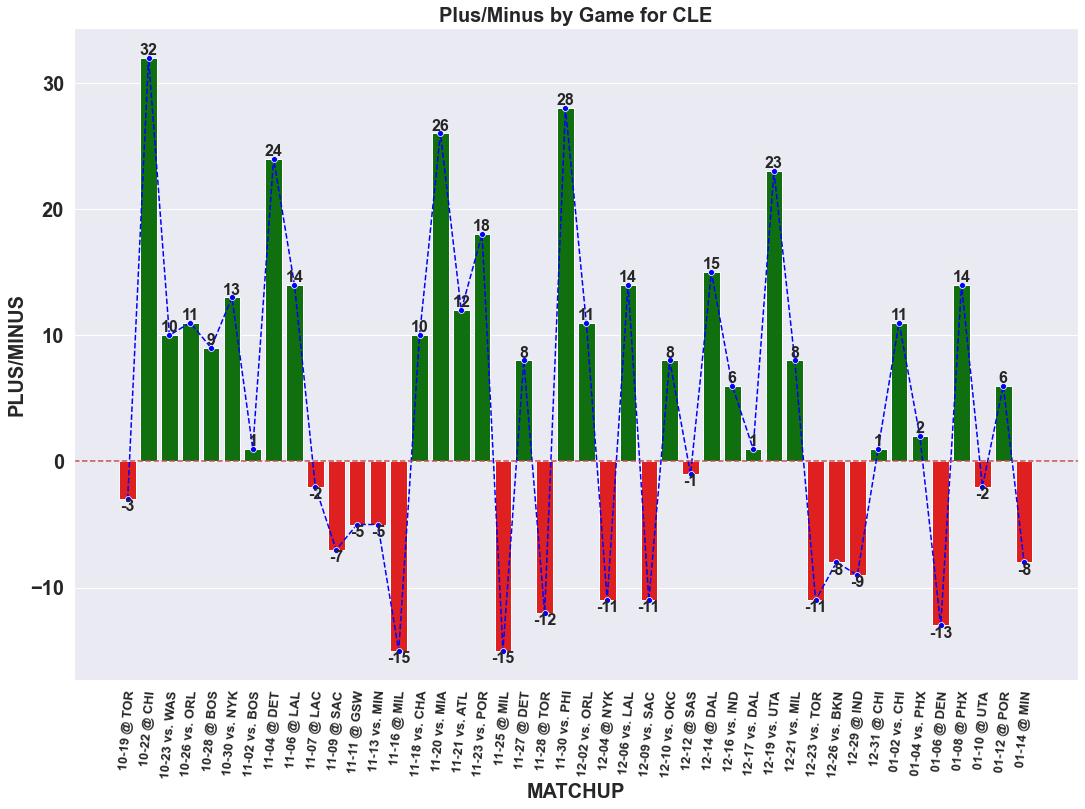

In [16]:
def plus_minus_plot(team_abbr):
    sns.set(rc={'figure.figsize':(18,12)})

    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    values = np.array(df.PLUS_MINUS)
    pal = ['green' if (i > 0) else 'red' for i in values ]
    
    ax1=sns.barplot(data=df, x=df.index, y=values, palette=pal)
    
    ax1.bar_label(ax1.containers[0], fontsize=16, fontweight='bold')
    plt.title(f"Plus/Minus by Game for {team_abbr}", fontsize=20, fontweight='bold')

    ax2=sns.lineplot(data=df, x=df.index, y="PLUS_MINUS",linestyle='--',color='blue', marker='o')
    plt.xticks(rotation=85)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.xticks(df.index,df["DATE_MATCHUP"].values, fontsize=13, fontweight='bold')
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    plt.ylabel('PLUS/MINUS', fontsize=20, fontweight='bold')

    plt.show()
    
plus_minus_plot('CLE')

## Scored vs Allowed Violin Plot Function

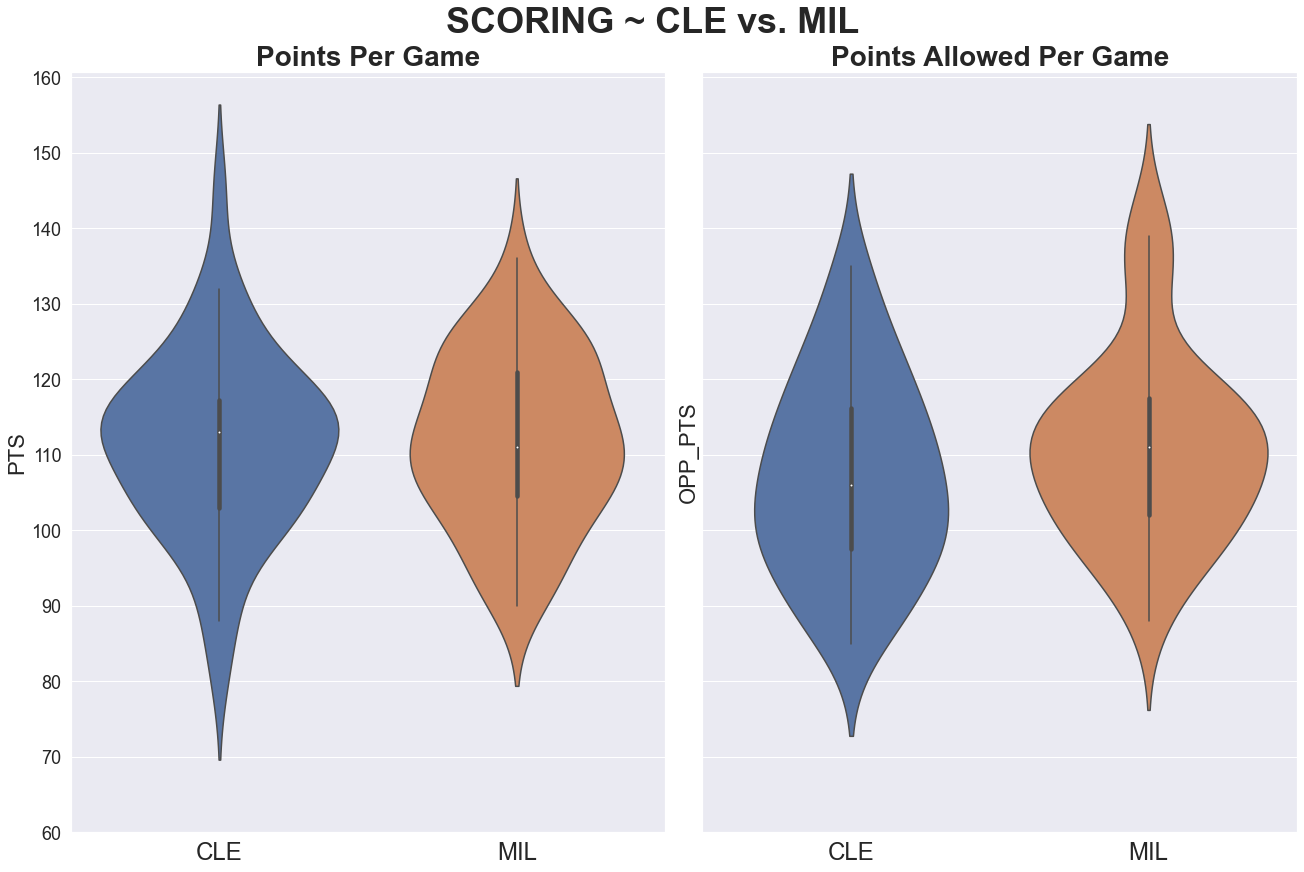

In [17]:
def scored_allowed_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    fig, axs = plt.subplots(ncols=2, sharey=True, constrained_layout=True)
    sns.set(rc={'figure.figsize':(18,12)})

    ax2 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OPP_PTS', ax=axs[1])
    ax2.set_title('Points Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.tick_params(axis='x', which='major', labelsize=24)
    ax2.set_xlabel('')
    ax2.set_ylabel('OPP_PTS', fontsize=22)

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='PTS', ax=axs[0])
    ax1.set_title('Points Per Game', fontsize=28, fontweight='bold')
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.set_ylabel('PTS', fontsize=22)
    ax1.set_xlabel('')

    plt.yticks([60,70,80,90,100,110,120,130,140,150,160])
    fig.suptitle(f'SCORING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=36, fontweight='bold')
    plt.show()
    
scored_allowed_compare("CLE", "MIL")

## Wins vs Losses Pie Charts Function

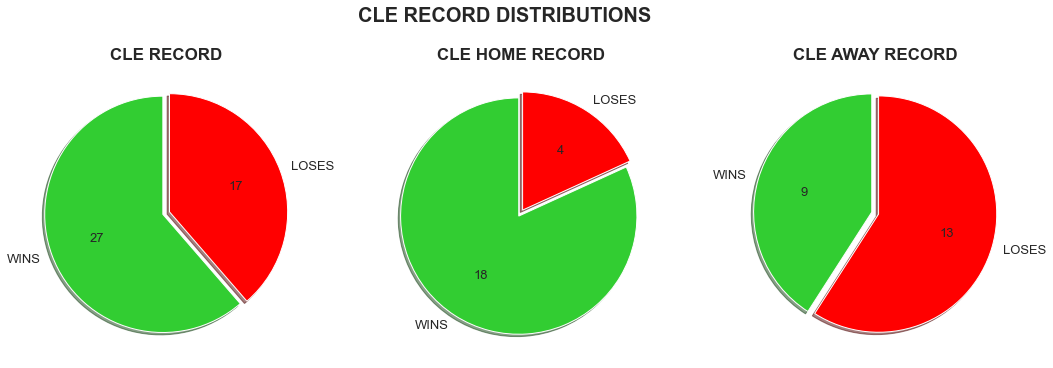

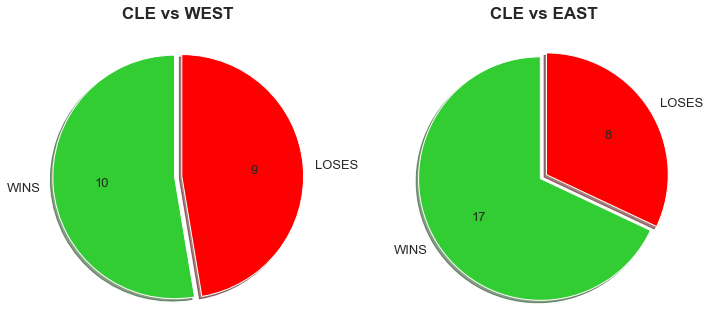

In [18]:
def wl_pies(team_abbr):
    wl_data = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].LOSES.item()])
    wl_data_home = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].HOME_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].HOME_LOSES.item()])
    wl_data_away = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].AWAY_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].AWAY_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl(val):
        a  = np.round(val/100.*wl_data.sum(), 0)
        return int(a)

    def absolute_value_wl_home(val):
        a  = np.round(val/100.*wl_data_home.sum(), 0)
        return int(a)

    def absolute_value_wl_away(val):
        a  = np.round(val/100.*wl_data_away.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


    ax[0].pie(wl_data,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} RECORD", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_home,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_home,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} HOME RECORD", fontsize= 17, fontweight='bold')

    ax[2].pie(wl_data_away,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_away,
            textprops={'fontsize': 13})
    ax[2].set_title(f"{team_abbr} AWAY RECORD", fontsize= 17, fontweight='bold')

    fig.suptitle(f'{team_abbr} RECORD DISTRIBUTIONS', fontsize=20, fontweight="bold")

    wl_pies_EW(team_abbr)

    plt.show()


def wl_pies_EW(team_abbr):
    wl_data_east = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].EAST_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].EAST_LOSES.item()])
    wl_data_west = np.array([df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].WEST_WINS.item(), df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr].WEST_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl_east(val):
        a  = np.round(val/100.*wl_data_east.sum(), 0)
        return int(a)

    def absolute_value_wl_west(val):
        a  = np.round(val/100.*wl_data_west.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


    ax[0].pie(wl_data_west,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_west,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} vs WEST", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_east,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_east,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} vs EAST", fontsize= 17, fontweight='bold')

    plt.show()
    
wl_pies("CLE")

## Multi Team Violin Plot Comparsion Function

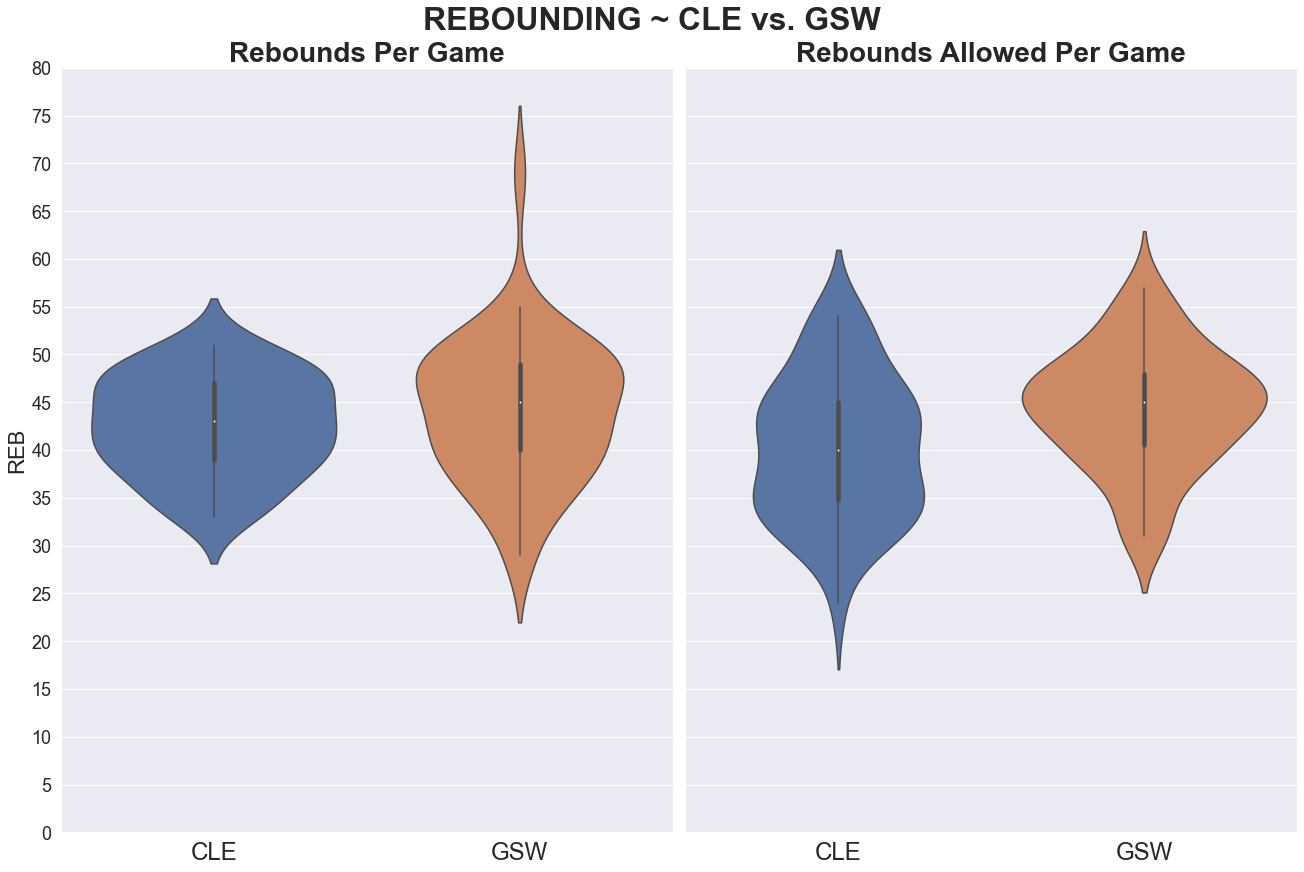

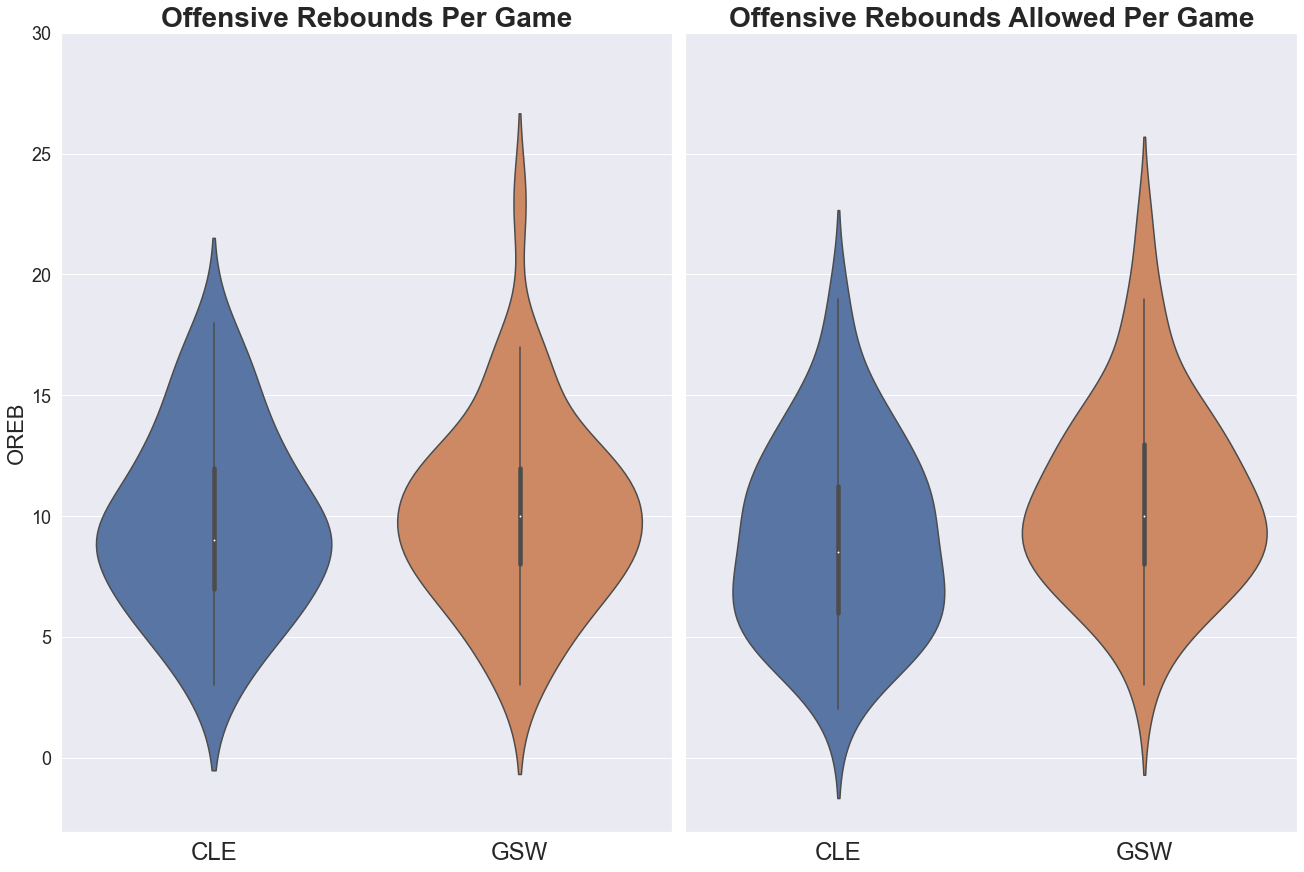

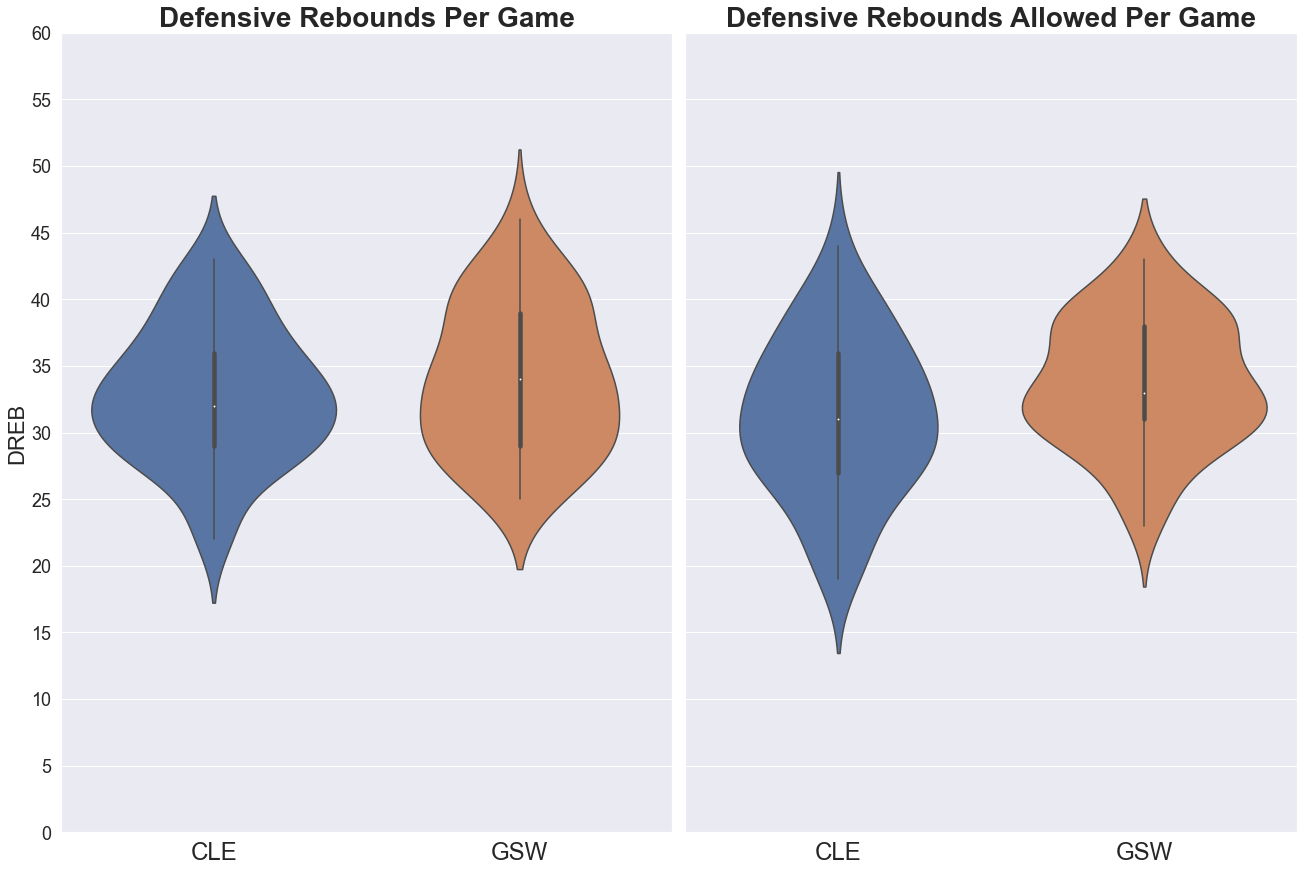

In [19]:
def rebounds_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='REB', ax=axs[0])
    ax1.set_title(f'Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('REB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='REB', ax=axs[1])
    ax2.set_title(f'Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40, 45, 50, 55, 60, 65, 70, 75, 80])

    fig.suptitle(f'REBOUNDING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=32, fontweight='extra bold')
    plt.show()

    print()
    oreb_compare(team_a_abbr,team_b_abbr)
    print()
    dreb_compare(team_a_abbr,team_b_abbr)
    print()

    # ADD REBOUNDING DIFFERENTIALS

def oreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OREB', ax=axs[0])
    ax1.set_title(f'Offensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('OREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='OREB', ax=axs[1])
    ax2.set_title(f'Offensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30])

    plt.show()

def dreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='DREB', ax=axs[0])
    ax1.set_title(f'Defensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('DREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='DREB', ax=axs[1])
    ax2.set_title(f'Defensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])

    plt.show()
    
rebounds_compare('CLE','GSW')

## Team Scoring Line Plot Function

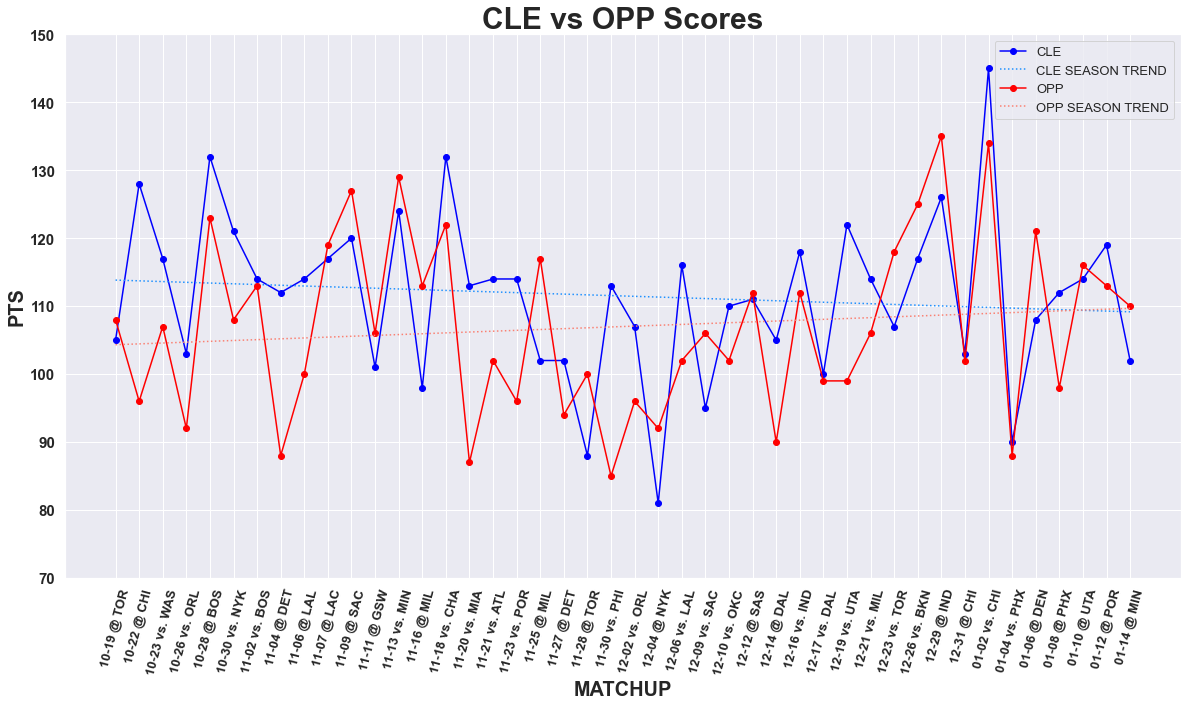

In [20]:
def line_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    team_score = plt.plot(df.index, df['PTS'], marker='o', label=team_abbr, color='blue')
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=1.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    opp_score = plt.plot(df.index, df['OPP_PTS'], marker='o', label='OPP', color='red')
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=1.5, color='salmon', label='OPP SEASON TREND')
    
    plt.legend(loc='best', fontsize=13)
    plt.title(f'{team_abbr} vs OPP Scores',fontsize=30, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15, fontweight='bold')
    plt.ylim(70, 150)
    plt.xlabel('MATCHUP',fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
line_plot_scores("CLE")

## Trend Plot Scores Function

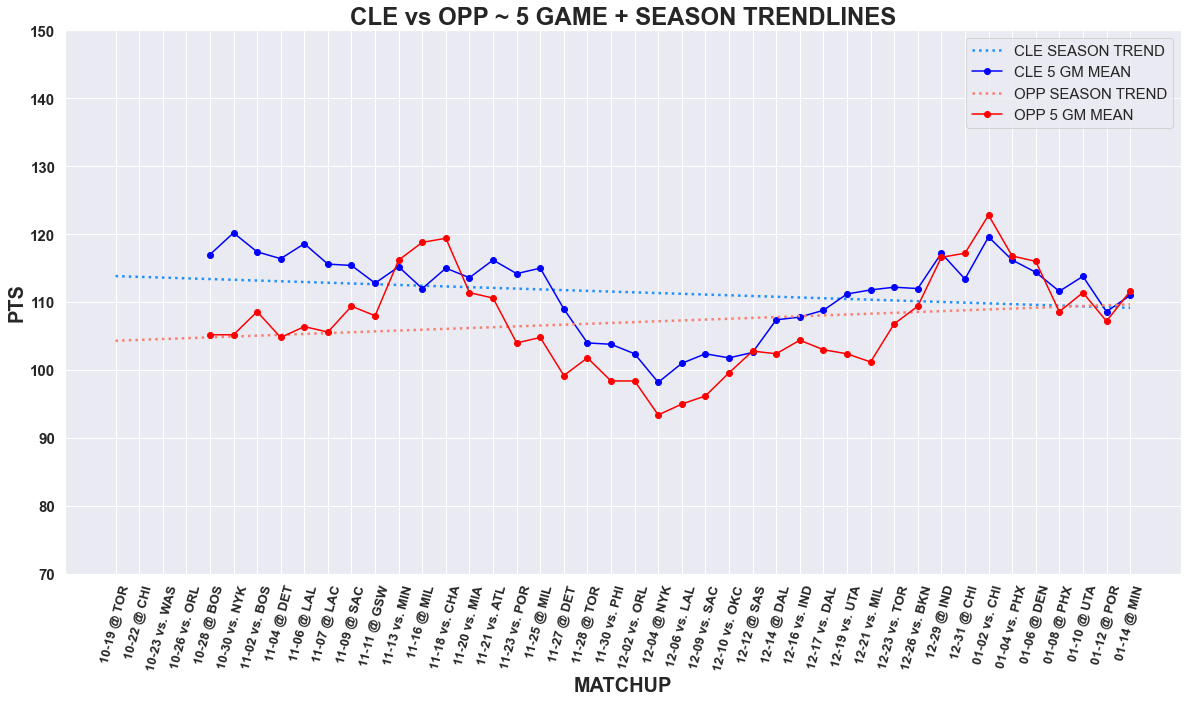

In [21]:
def trend_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=2.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    rolling_mean = df.PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="BLUE", alpha=1,marker='o', label=f"{team_abbr} 5 GM MEAN")
    
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=2.5, color='salmon', label='OPP SEASON TREND')
    
    rolling_mean = df.OPP_PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="RED", alpha=1,marker='o', label=f"OPP 5 GM MEAN")
    
    plt.legend(loc='best', fontsize=15)
    plt.title(f'{team_abbr} vs OPP ~ 5 GAME + SEASON TRENDLINES',fontsize=24, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15,  fontweight='bold')
    plt.ylim(70, 150)
    
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
trend_plot_scores("CLE")

## Shooting Distribution Pie Chart Function

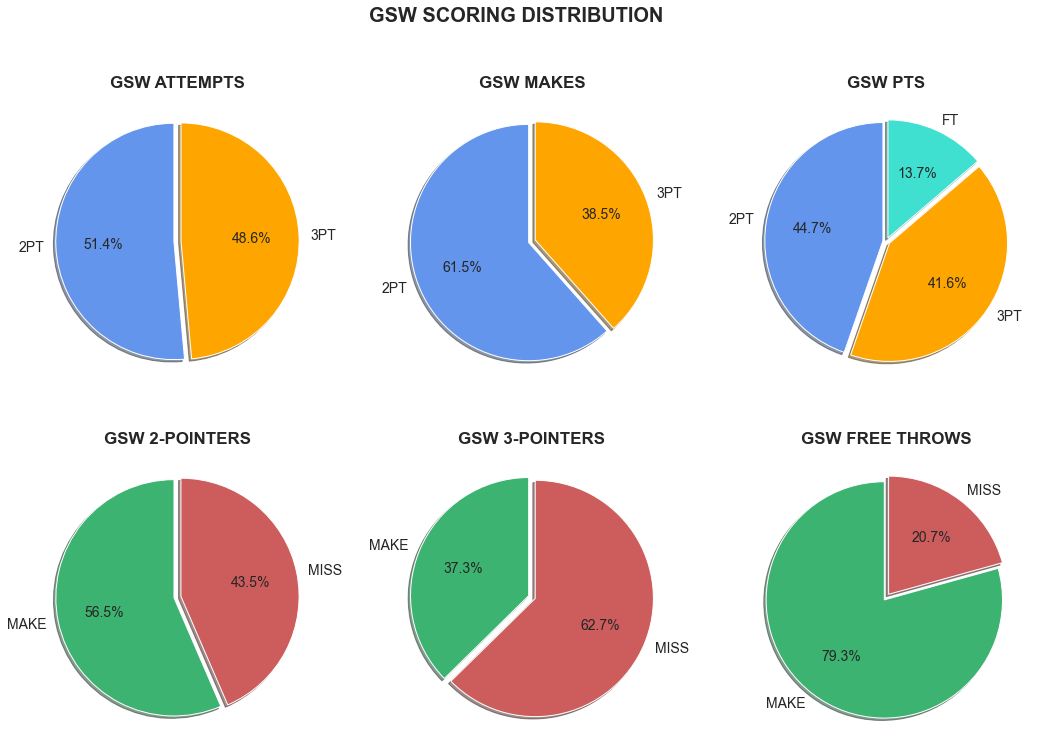

In [22]:
def shot_pies(team_abbr):
    
    df_team = df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr]
    
    data_att = [df_team.FRAC_ATT_2PT.item(), df_team.FRAC_ATT_3PT.item()]
    data_mk = [df_team.FRAC_MK_2PT.item(), df_team.FRAC_MK_3PT.item()]
    data_pts = [df_team.FRAC_PTS_2PT.item(), df_team.FRAC_PTS_3PT.item(), df_team.FRAC_PTS_FT.item()]
    
    data_2pt = [df_team.FG2M.item(), (df_team.FG2A.item() - df_team.FG2M.item())]
    data_3pt = [df_team.FG3M.item(), (df_team.FG3A.item() - df_team.FG3M.item())]
    data_ft = [df_team.FTM.item(), (df_team.FTA.item() - df_team.FTM.item())]
    
    labels1 = ['2PT', '3PT']
    labels2 = ['2PT', '3PT', 'FT']
    labels3 = ['MAKE', 'MISS']
    explode1 = [0.03, 0.03]
    explode2 = [0.03,0.03,0.03]
    colors0 = ['cornflowerblue', 'orange']
    colors1= ['cornflowerblue', 'orange', 'turquoise']
    colors2 = ['mediumseagreen','indianred']
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    
    ax[0,0].pie(data_att,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,0].set_title(f'{team_abbr} ATTEMPTS', fontsize=17, fontweight='bold')
    
    ax[0,1].pie(data_mk,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,1].set_title(f'{team_abbr} MAKES', fontsize=17, fontweight='bold')
    
    ax[0,2].pie(data_pts,
              labels=labels2,
              explode=explode2,
              shadow=True,
              colors=colors1,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,2].set_title(f'{team_abbr} PTS', fontsize=17, fontweight='bold')
    
    ax[1,0].pie(data_2pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,0].set_title(f'{team_abbr} 2-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,1].pie(data_3pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,1].set_title(f'{team_abbr} 3-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,2].pie(data_ft,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,2].set_title(f'{team_abbr} FREE THROWS', fontsize=17, fontweight='bold')
    
    fig.suptitle(f'{team_abbr} SCORING DISTRIBUTION', fontsize=20, fontweight="bold")
    plt.show()
    
shot_pies('GSW')

# Regrssion Analysis Plots ~ League Trends

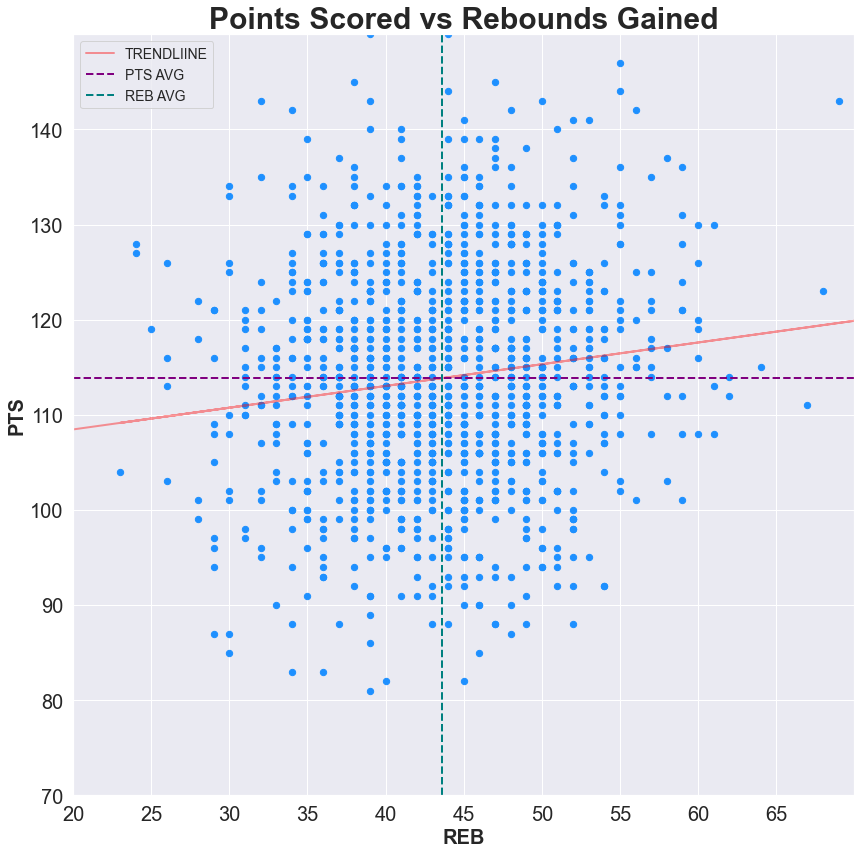

Season Trend Line Equation
y=0.228427x+(103.891248)

R-squared: 0.016791236475797056

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.1968
Date:                Mon, 16 Jan 2023   Prob (F-statistic):              0.661
Time:                        13:45:58   Log-Likelihood:                -75.850
No. Observations:                  31   AIC:                             155.7
Df Residuals:                      29   BIC:                             158.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [23]:
plt.rcParams["figure.figsize"] = (14,14)

x=df.REB
y=df.PTS

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.4, color='red', linewidth=2)

plt.scatter(x,y, color='dodgerblue', s=40)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.REB.mean(), label="REB AVG", linestyle='dashed', color='teal', linewidth=2)

plt.xlim(20,70)
plt.xticks(list(range(20,70,5)), fontsize=20)
plt.xlabel('REB', fontsize=20, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20)
plt.ylabel('PTS', fontsize=20, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Rebounds Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' +color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ REB', data=df_team_avg).fit()
print()
print(lm.summary())

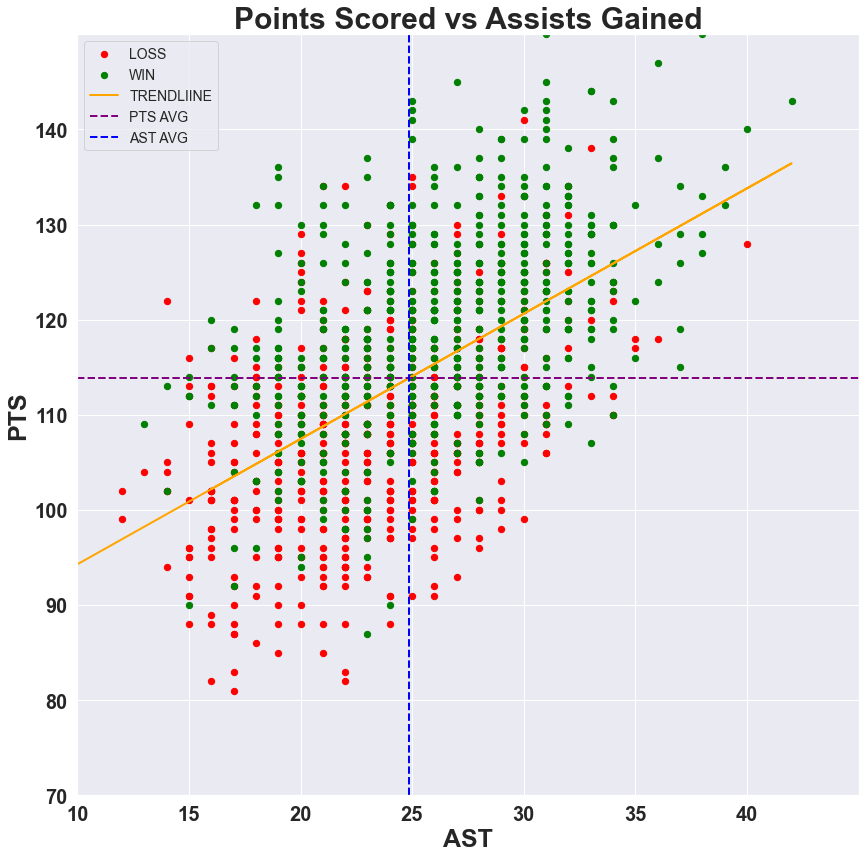

Season Trend Line Equation
y=1.317130x+(81.112298)

R-squared: 0.292311785963255

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     21.92
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           6.14e-05
Time:                        13:45:59   Log-Likelihood:                -67.229
No. Observations:                  31   AIC:                             138.5
Df Residuals:                      29   BIC:                             141.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [24]:
plt.rcParams["figure.figsize"] = (14,14)

x=df.AST
y=df.PTS

x_L=df[df.WL=='L'].AST
y_L=df[df.WL=='L'].PTS

x_W=df[df.WL=='W'].AST
y_W=df[df.WL=='W'].PTS

plt.scatter(x_L,y_L, color='red', label='LOSS', s=40)
plt.scatter(x_W,y_W, color='green', label='WIN', s=40)

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=1, color='orange', linewidth=2)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.AST.mean(), label="AST AVG", linestyle='dashed', color='blue', linewidth=2)

plt.xlim(10,45)
plt.xticks(list(range(10,45,5)), fontsize=20, fontweight='bold')
plt.xlabel('AST', fontsize=25, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20, fontweight='bold')
plt.ylabel('PTS', fontsize=25, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Assists Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' + color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ AST', data=df_team_avg).fit()
print()
print(lm.summary())

## Team Average Reression (statx vs staty) Plot and Analysis Function

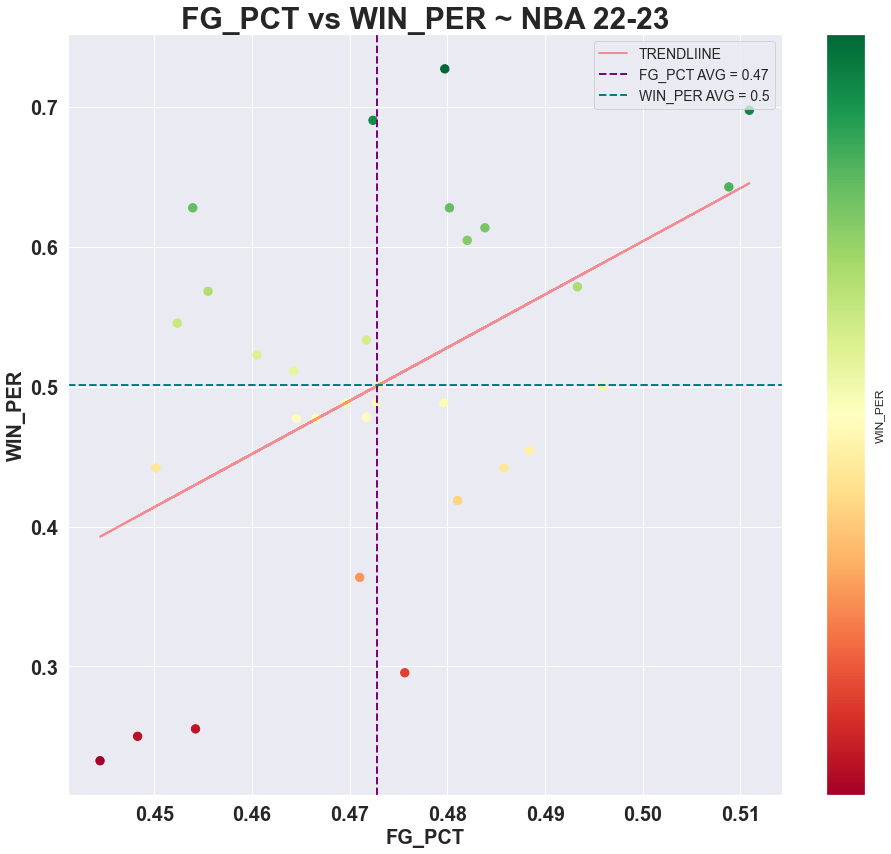


Season Trend Line Equation: y = 3.802301x + (-1.297150)

R-squared: 0.24312332919344692


                            OLS Regression Results                            
Dep. Variable:                WIN_PER   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     9.315
Date:                Mon, 16 Jan 2023   Prob (F-statistic):            0.00483
Time:                        13:45:59   Log-Likelihood:                 24.639
No. Observations:                  31   AIC:                            -45.28
Df Residuals:                      29   BIC:                            -42.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [25]:
def regression_analysis_team_avg(statx, staty):
    plt.rcParams["figure.figsize"] = (16,14)

    x=df_team_avg[statx]
    y=df_team_avg[staty]

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.4, color='red', linewidth=2)

    plt.scatter(x,y, c=y, cmap='RdYlGn', s=70)

    plt.axvline(df.FG_PCT.mean(), label=f"{statx} AVG = {round(df_team_avg[df_team_avg['TEAM_ABBR']=='NBA'][statx].item(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(df_team_avg.WIN_PER.mean(), label=f"{staty} AVG = {round(df_team_avg[df_team_avg['TEAM_ABBR']=='NBA'][staty].item(),2)}", linestyle='dashed', color='teal', linewidth=2)

    plt.xlabel(statx, fontsize=20, fontweight='bold')
    plt.ylabel(staty, fontsize=20, fontweight='bold')

    plt.legend(loc='best', fontsize=14)

    plt.title(f'{statx} vs {staty} ~ NBA 22-23', fontsize=30, fontweight='bold')
    plt.colorbar(label=staty, ticks=np.linspace(0.2,0.,8))
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()

    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_team_avg).fit()
    print()
    print(lm.summary())
    

regression_analysis_team_avg('FG_PCT', 'WIN_PER')

# Team Report Function

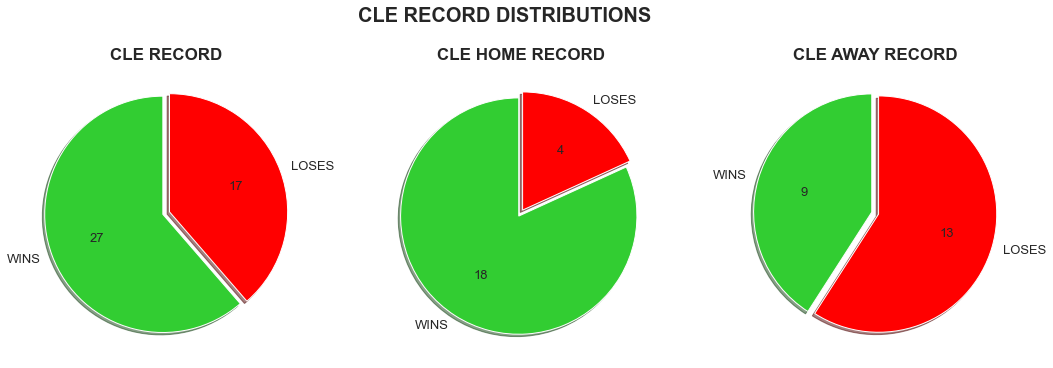

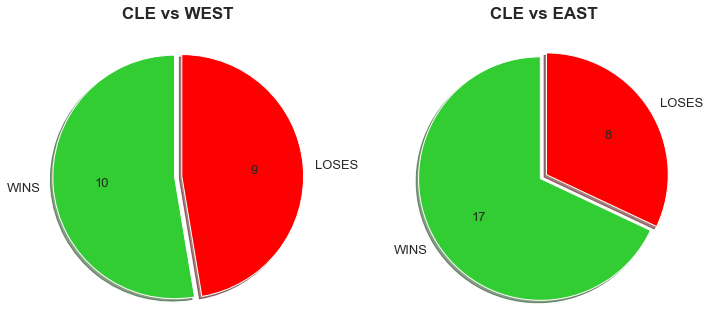

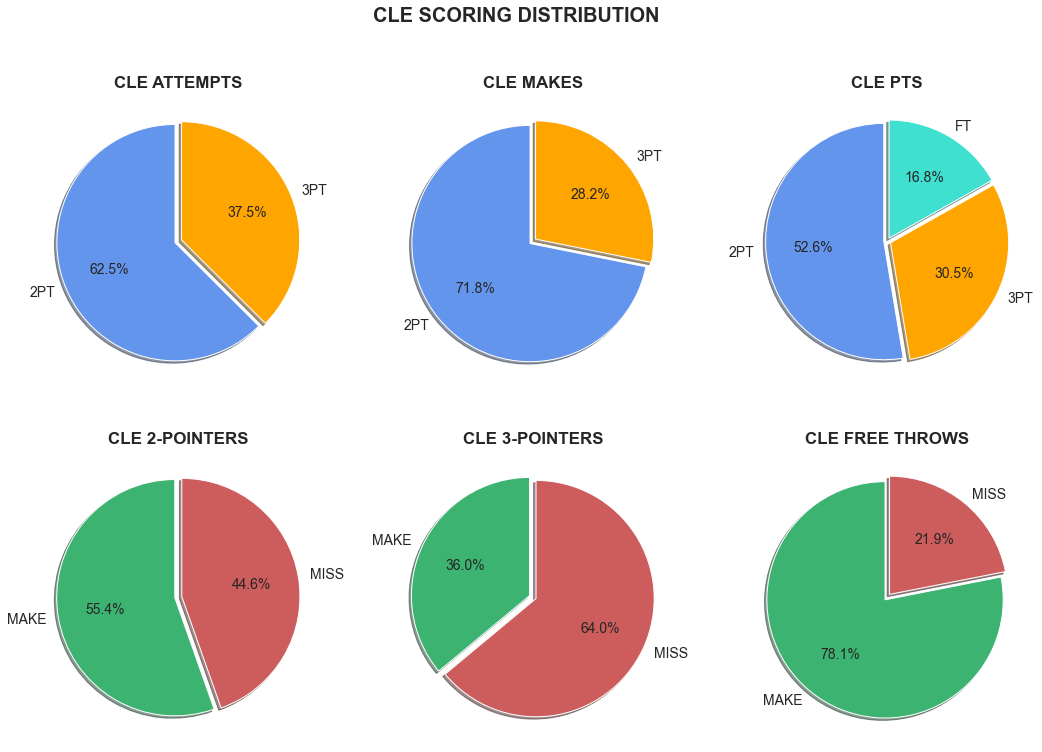

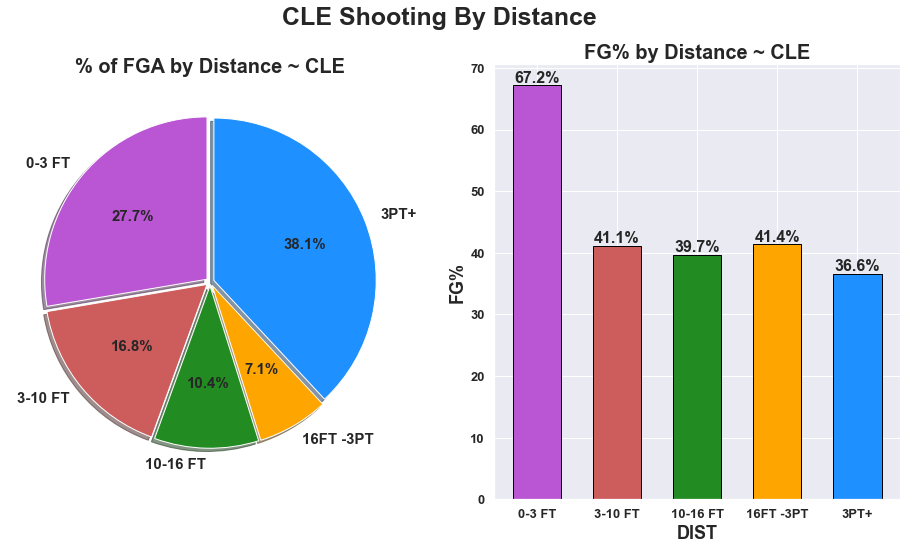

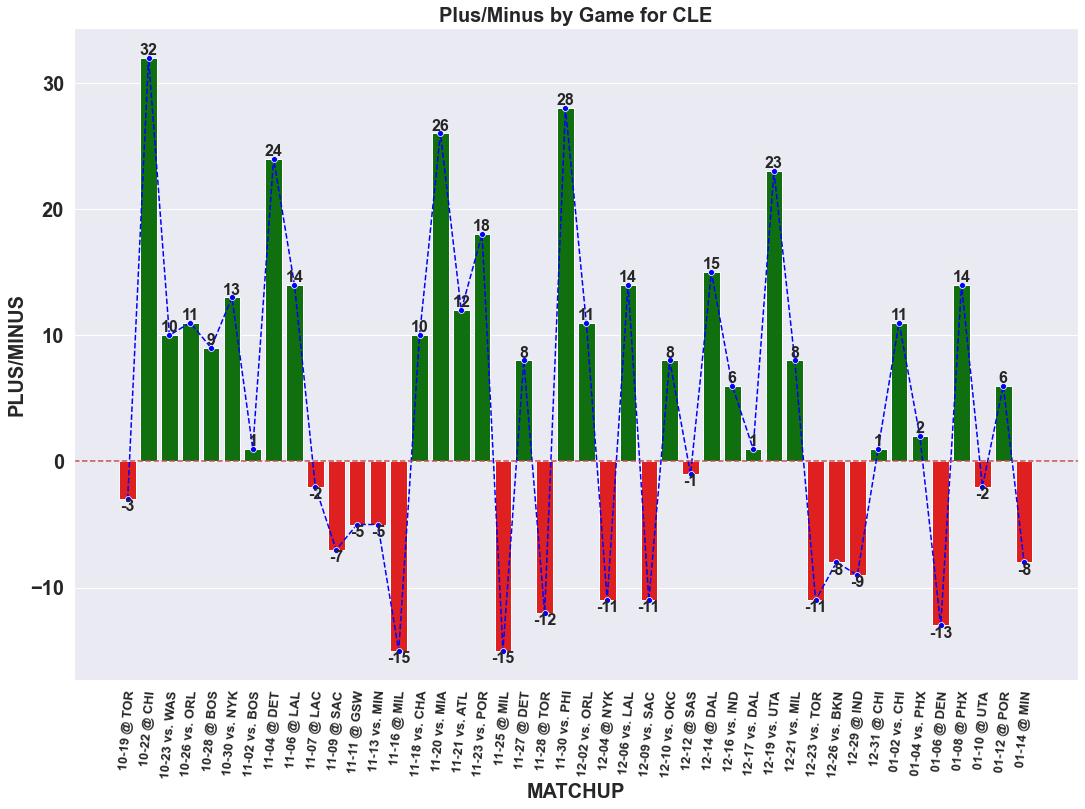

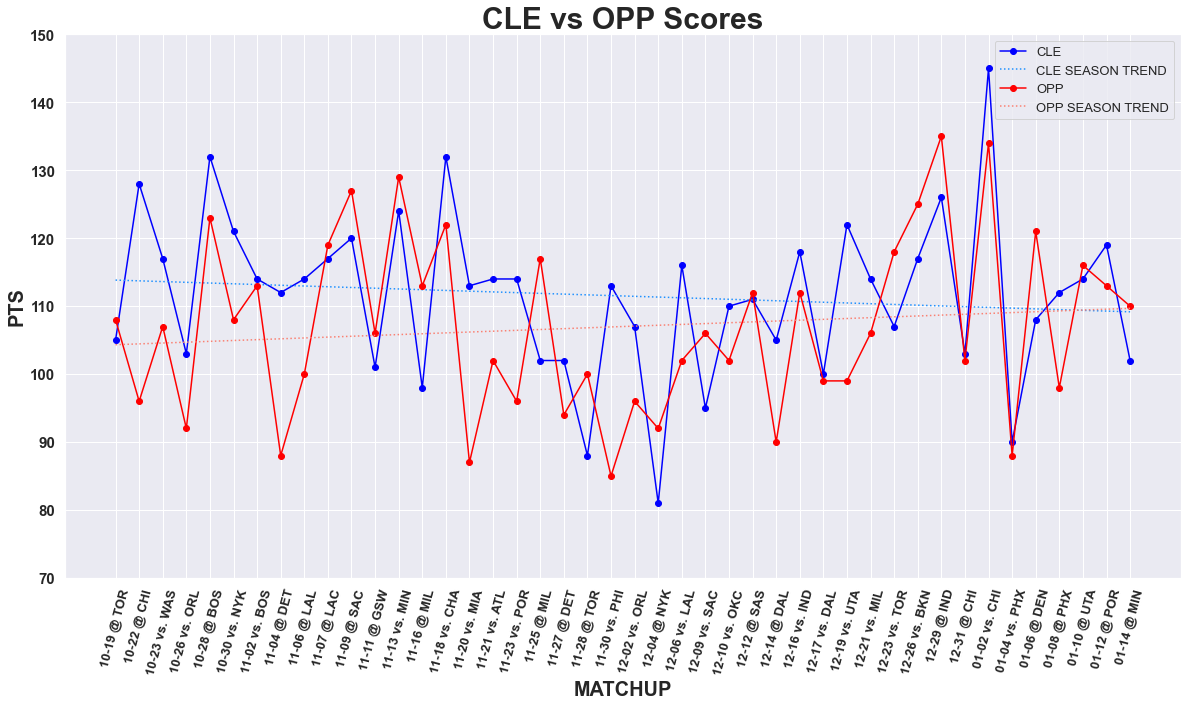

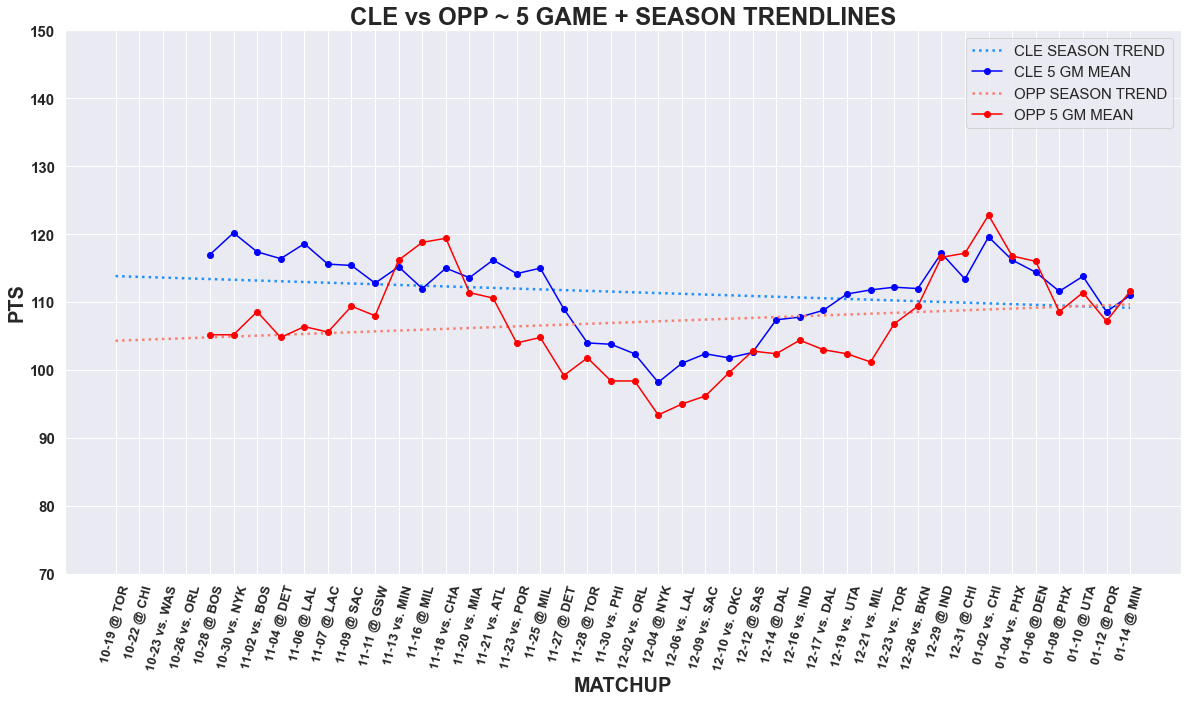

In [26]:
#NBA TEAM REPORT

def team_report(team_abbr):
    wl_pies(team_abbr)
    shot_pies(team_abbr)
    team_fg_by_dist(team_abbr)
    plus_minus_plot(team_abbr)
    line_plot_scores(team_abbr)
    trend_plot_scores(team_abbr)
    
team_report("CLE")

# 2-Team Comparison Function

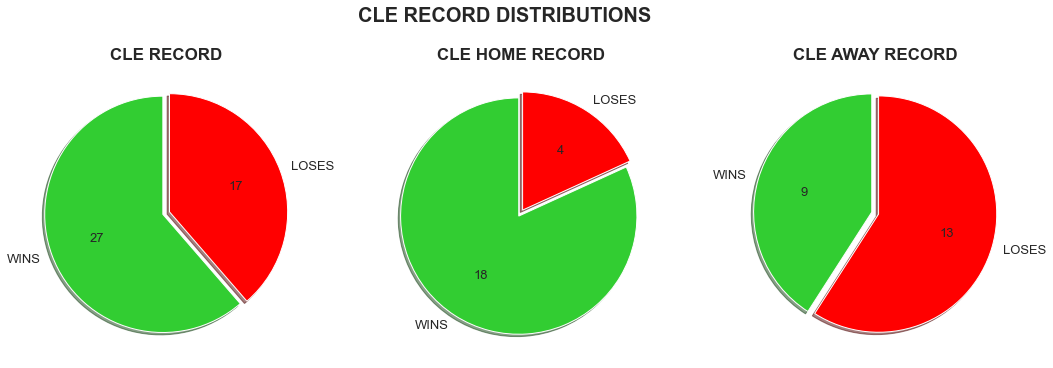

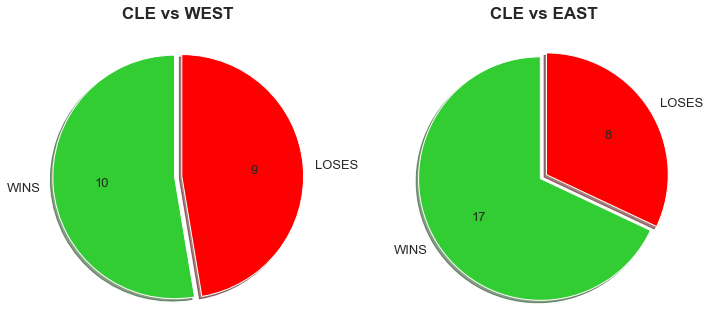

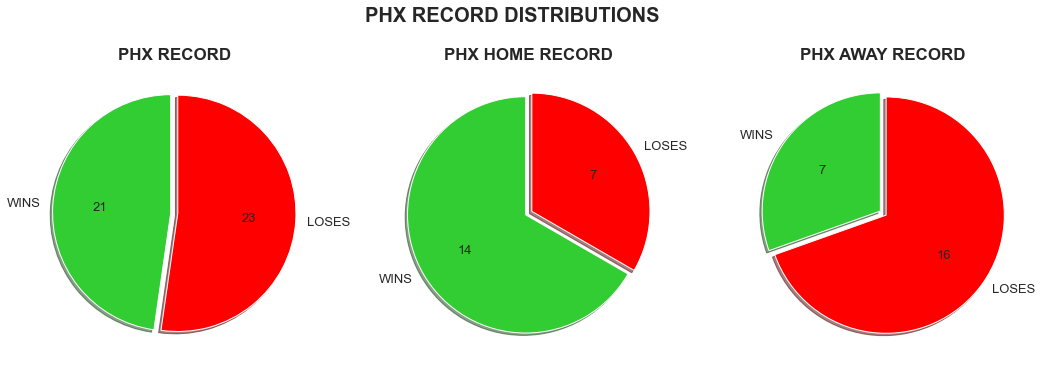

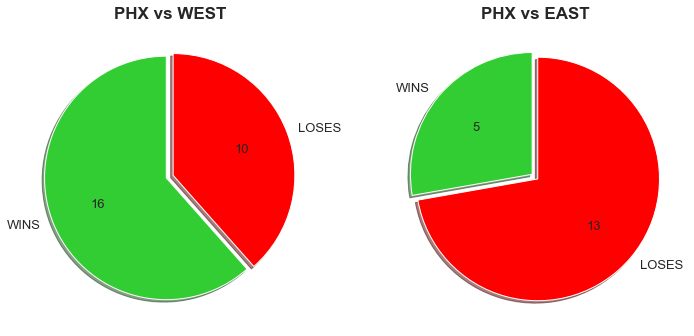

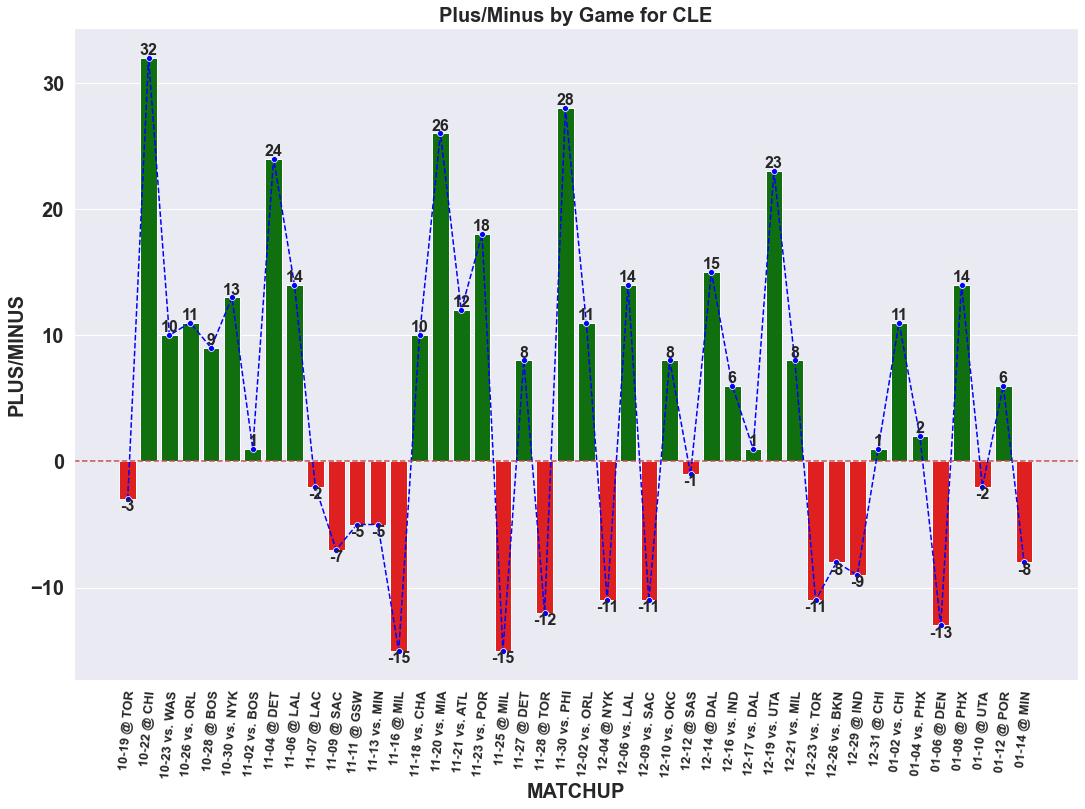

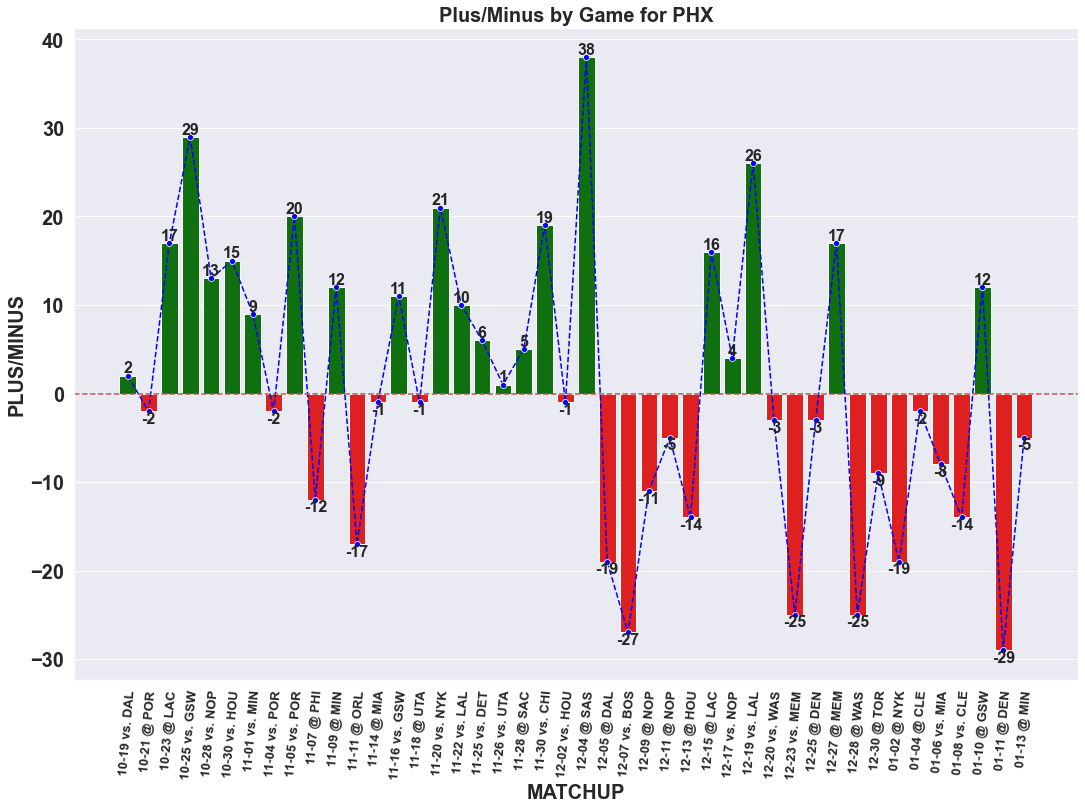

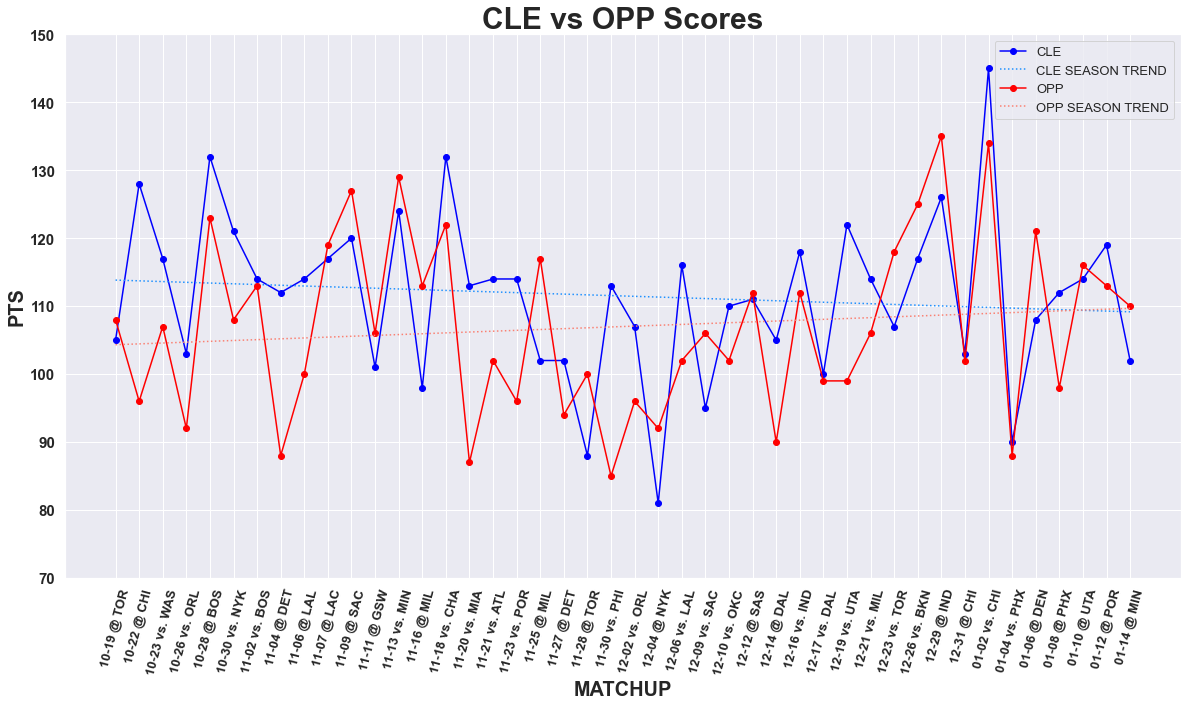

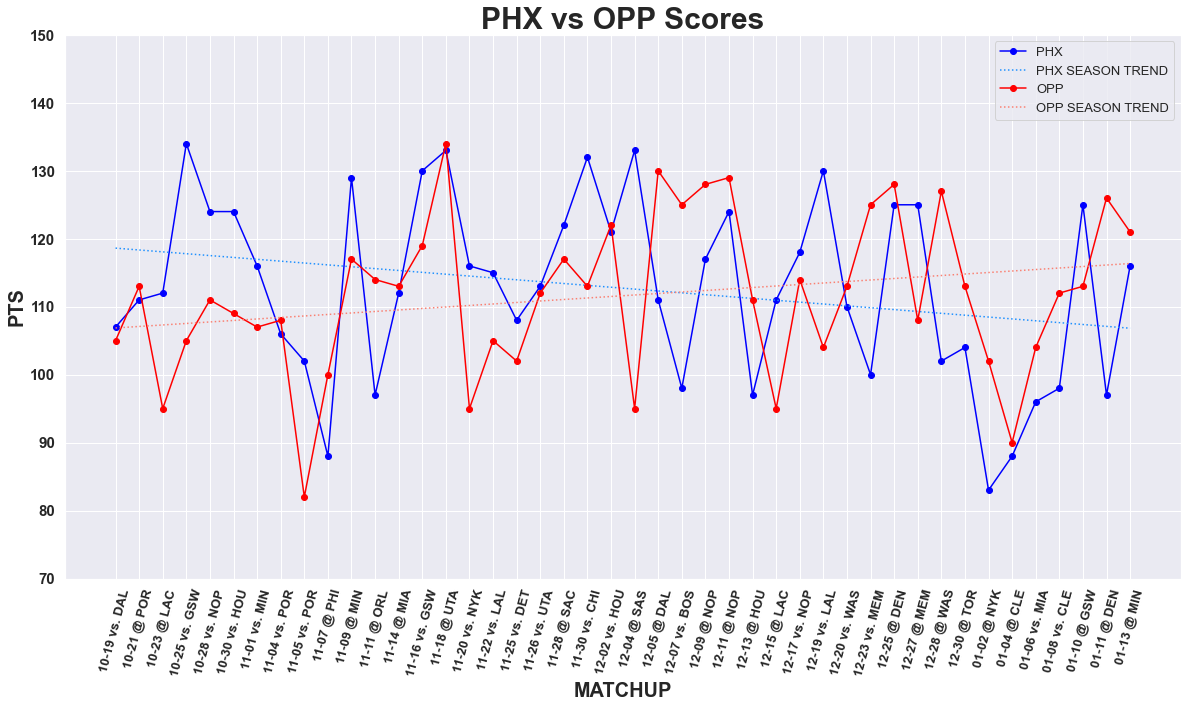

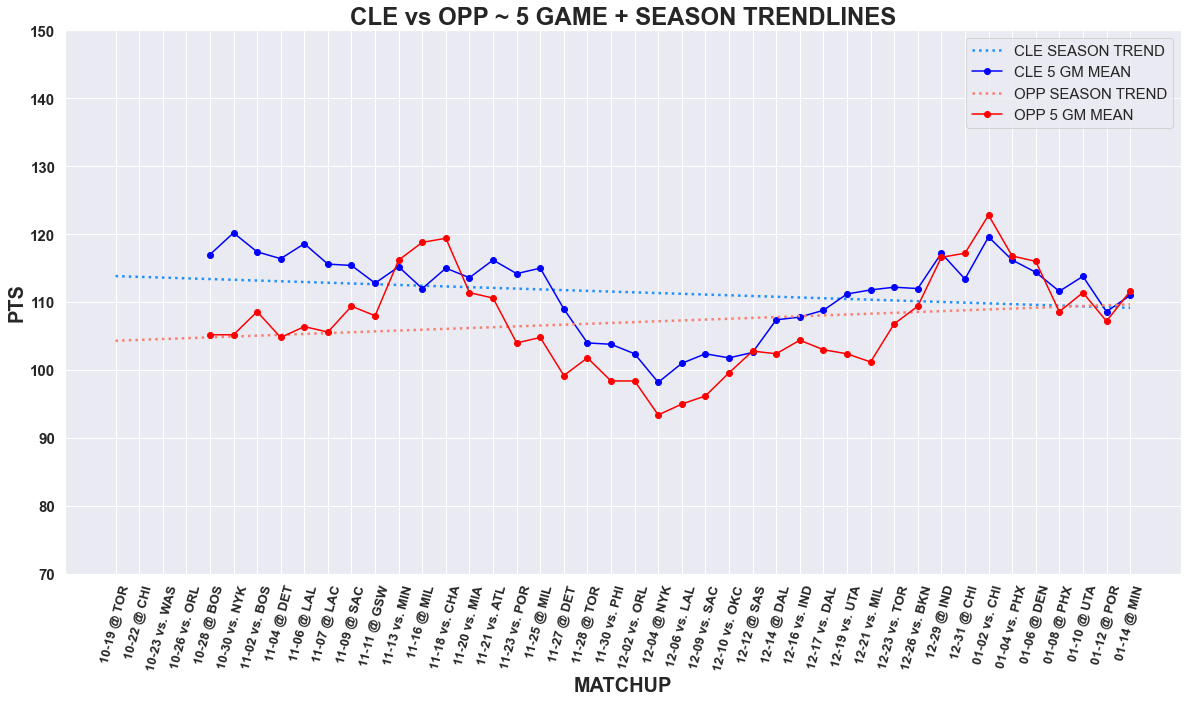

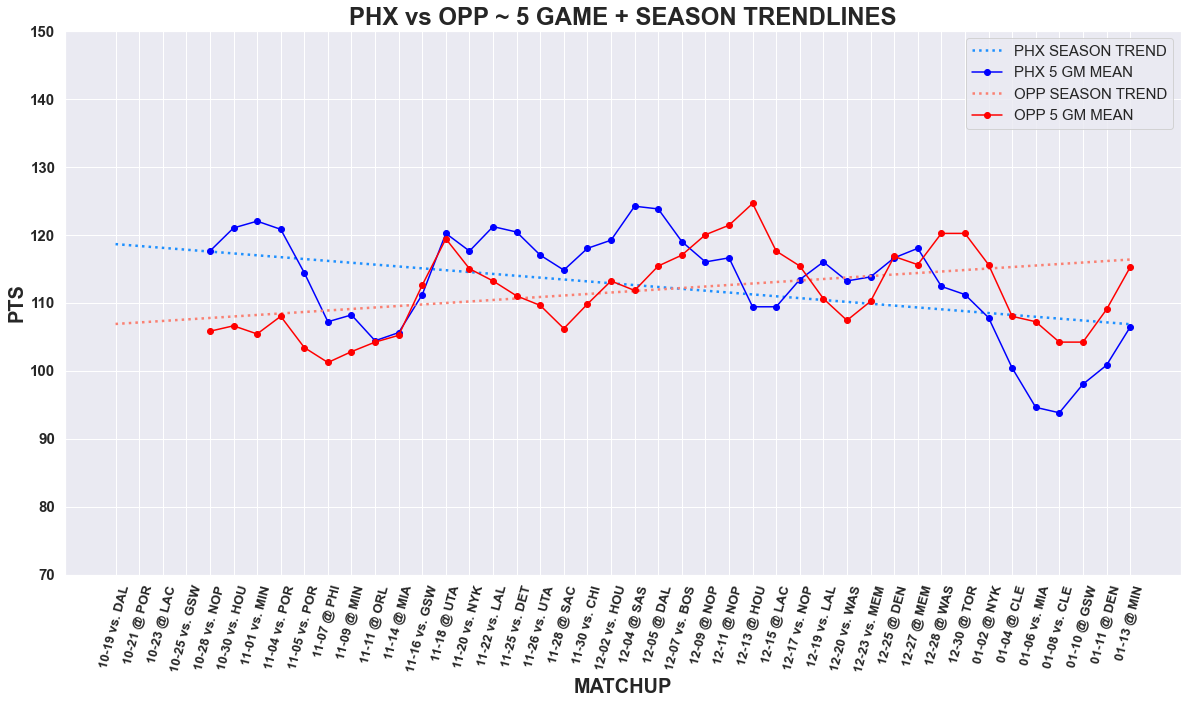

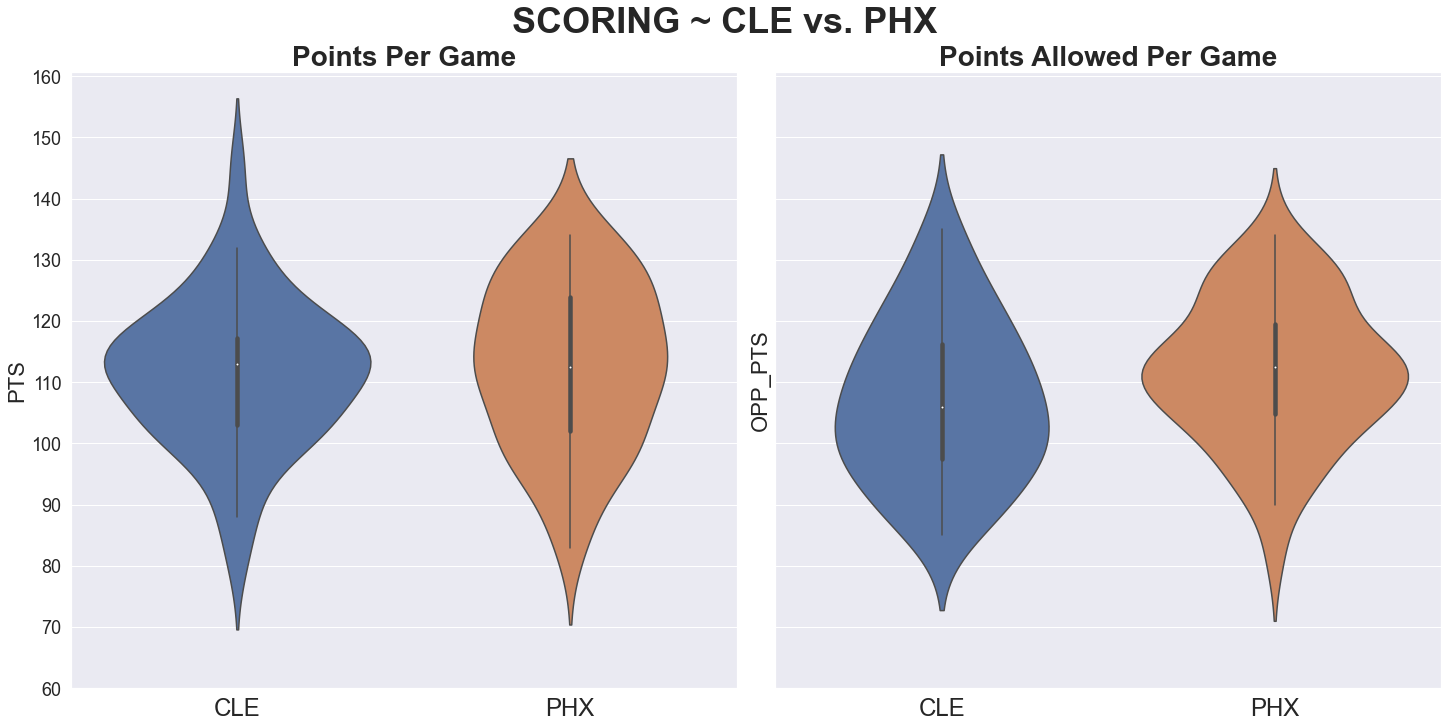

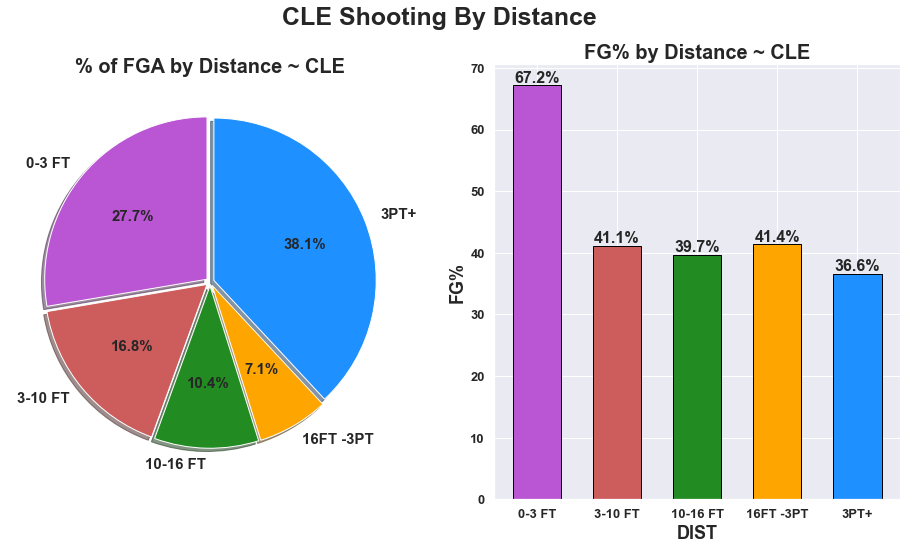

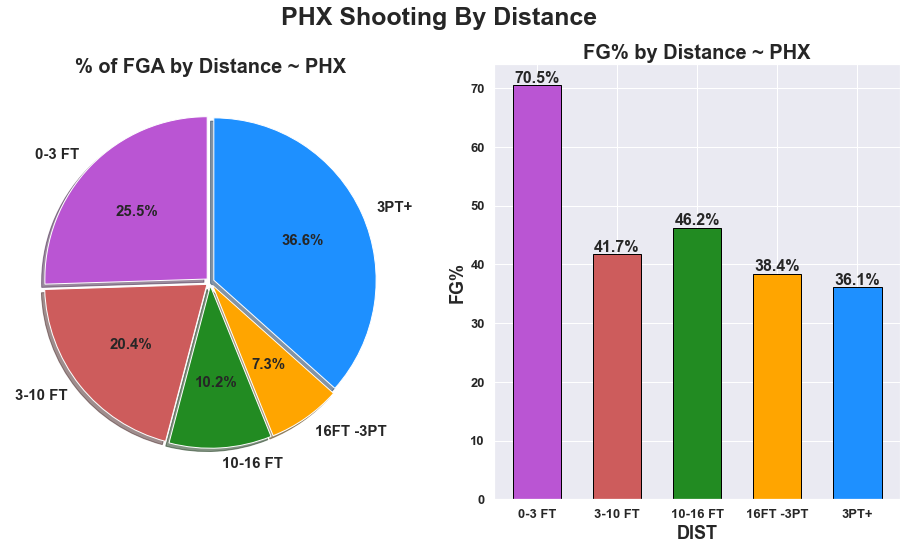

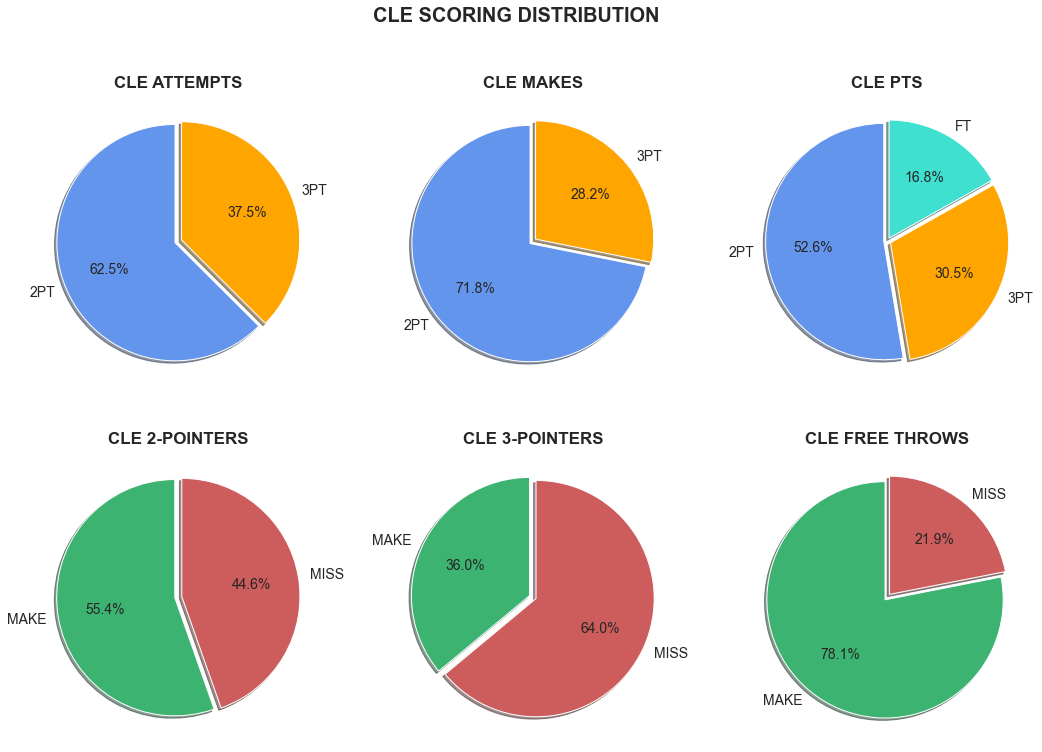

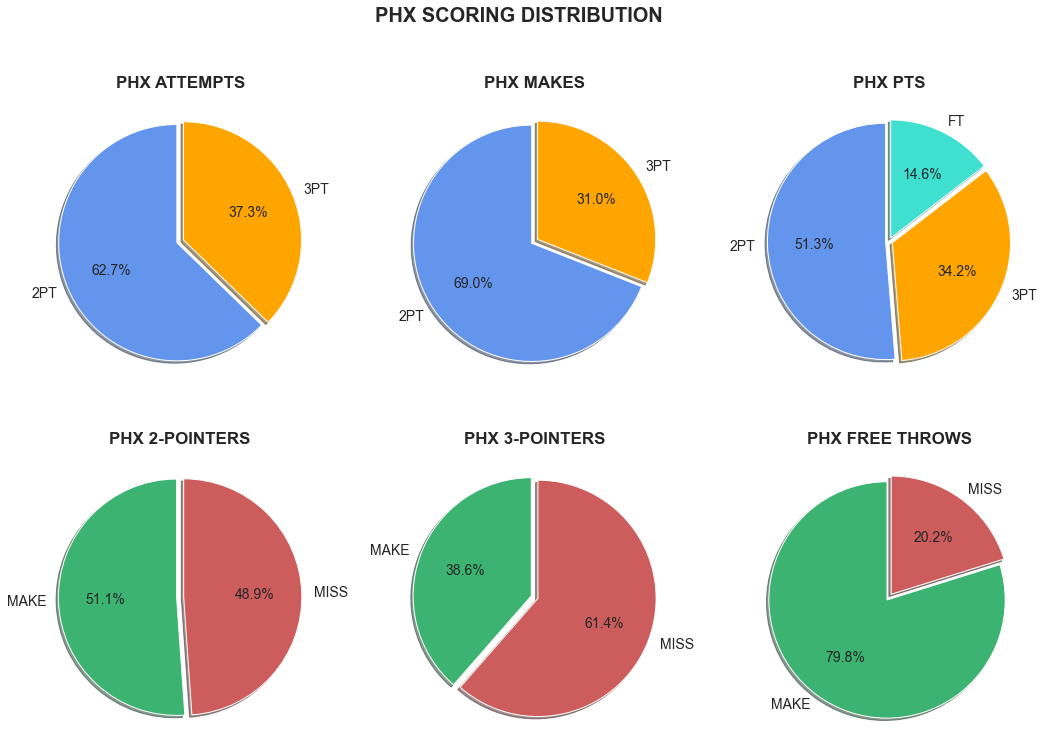

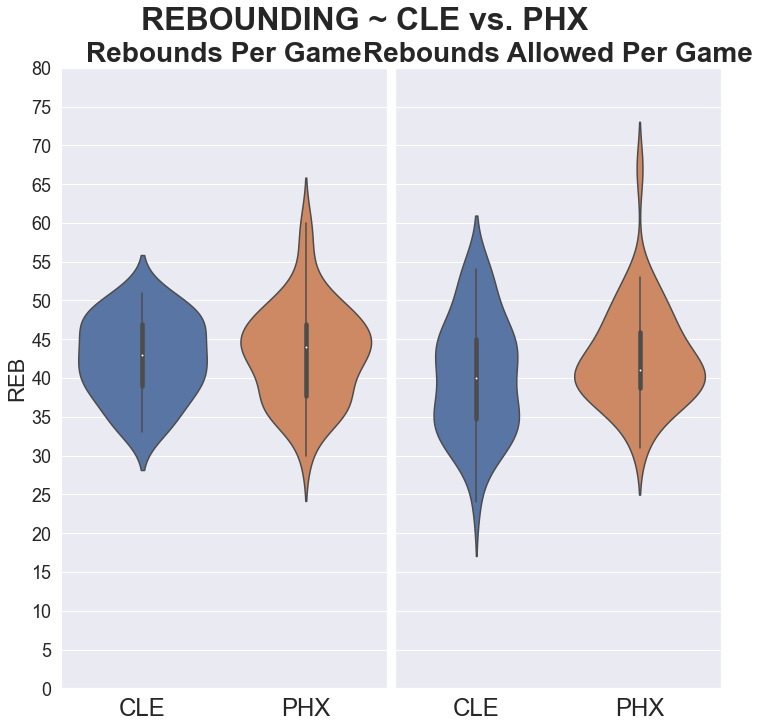

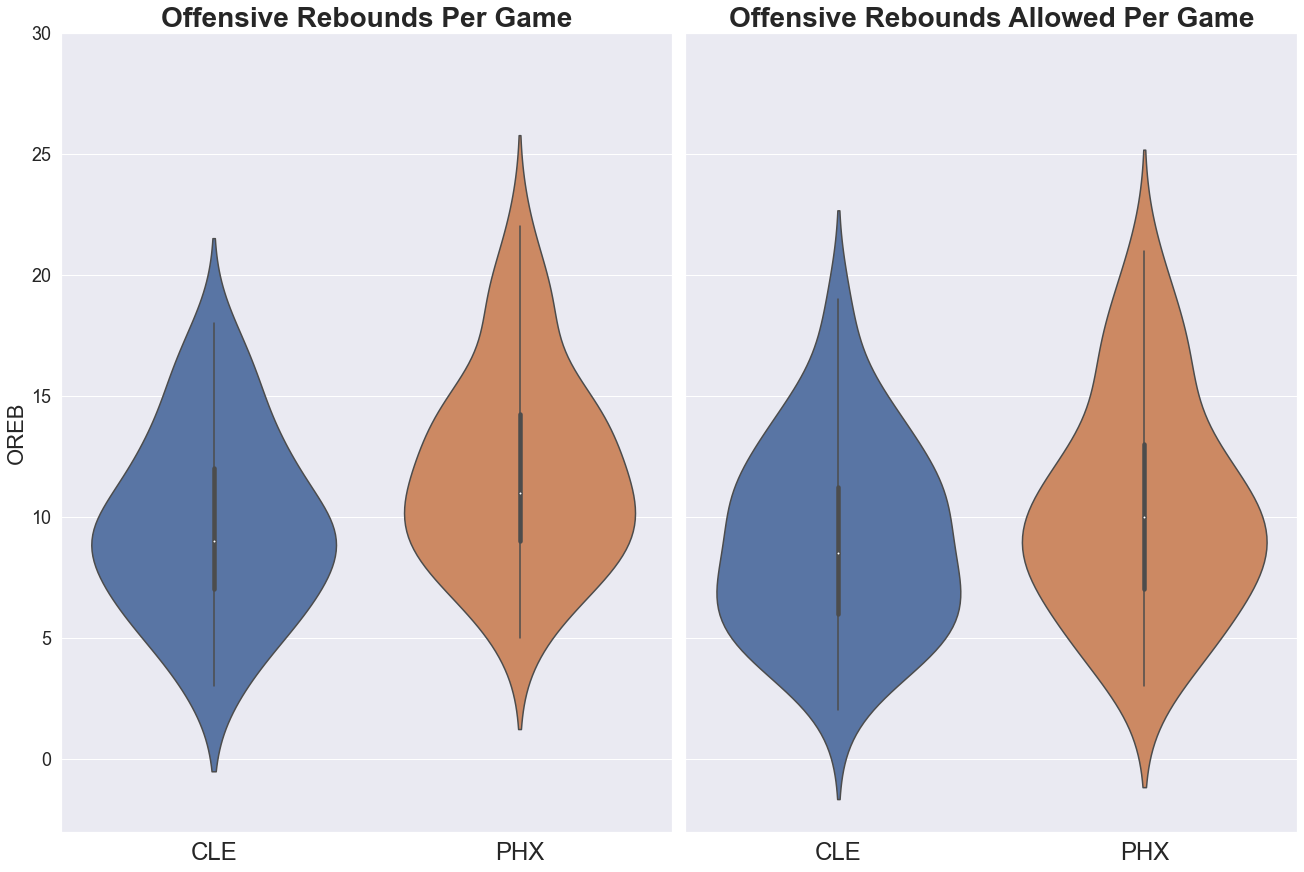

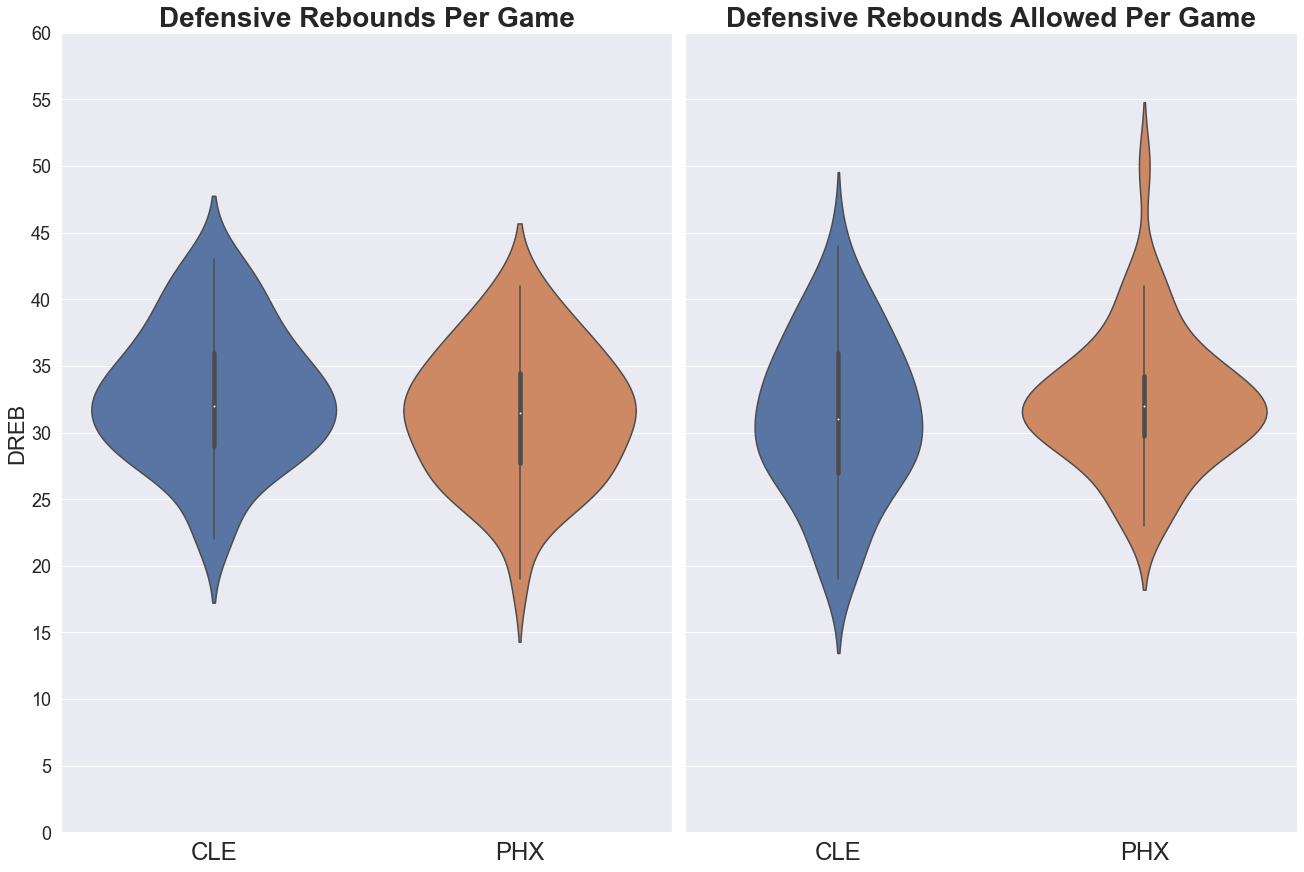

In [27]:
def compare_teams(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])
    
    wl_pies(team_a_abbr)
    wl_pies(team_b_abbr)
    
    plus_minus_plot(team_a_abbr)
    plus_minus_plot(team_b_abbr)
    
    line_plot_scores(team_a_abbr)
    line_plot_scores(team_b_abbr)
    
    trend_plot_scores(team_a_abbr)
    trend_plot_scores(team_b_abbr)
    
    scored_allowed_compare(team_a_abbr, team_b_abbr)
    
    team_fg_by_dist(team_a_abbr)
    team_fg_by_dist(team_b_abbr)
    
    shot_pies(team_a_abbr)
    shot_pies(team_b_abbr)
    
    rebounds_compare(team_a_abbr, team_b_abbr)
    
    plt.show()

compare_teams('CLE','PHX')